In [ ]:
Turtle Games: Customer Loyalty Points 

Course: LSE DA301 | Student: Monica Baracho | Date: 21 Jun 




## Business Question 

###  Turtle Games seeks to optimise its loyalty program by understanding which customer attributes drive loyalty point accumulation. This notebook explores predictive relationships using regression models and segmentation techniques, aiming to guide marketing and retention strategies.

# Executive Summary

This notebook explores customer engagement at Turtle Games through loyalty points. Using demographic and behavioral data, we:
- Predicted loyalty points using regression and decision trees
- Identified income and spending-based customer segments via clustering
- Analyzed sentiment from customer reviews to inform marketing

Key findings:
- Spending behavior is the strongest predictor of loyalty
- Mid-income customers (£50k–£70k) consistently earn higher loyalty points
- Positive sentiment correlates with higher spending and engagement

Recommendations:
- Prioritize engaged spenders with loyalty campaigns
- Target mid-income, educated customers for upselling
- Use sentiment monitoring to flag products for promotion or review


## Assignment Activity 1: Making Predictions with regression

In this section, we aim to understand how customer characteristics such as age, remuneration, and spending score relate to loyalty point accumulation. We apply linear regression techniques to build a model that can predict loyalty points and inform Turtle Games' marketing strategy.



## Environment and Reproducibility

All analyses in this notebook were performed using a dedicated Conda environment to ensure reproducibility and compatibility.

The environment was created with the following command:

```bash
conda create --name turtle_env python=3.12

All required packages were installed inside the environment, and the full specification was exported using:

conda env export --name turtle_env > environment.yml

To replicate this environment:

Ensure Conda is installed
Run the following in your terminal:
conda env create -f environment.yml
Activate the environment:
conda activate turtle_env
This guarantees that all package versions match and the notebook can be executed as intended.

Why spaCy?
We need spaCy’s production-grade tokenizer, lemmatizer and POS-tagger for the sentiment-analysis pipeline; lighter regex methods miss compound tokens and contractions.



In [1]:
import os

current_directory = os.getcwd()
print("Current directory:", current_directory)





Current directory: /Users/monicabaracho/Desktop/LSE_DA301_Module3/Baracho_Monica_DA301_FINAL


In [2]:
import sys
print(sys.executable)


/opt/anaconda3/envs/turtle_env/bin/python


In [3]:
import spacy

# Check the version installed
print("spaCy version:", spacy.__version__)


# Try loading the English model to ensure everything is working
nlp = spacy.load("en_core_web_sm")
print("spaCy model loaded successfully!")


spaCy version: 3.8.6
spaCy model loaded successfully!


In [4]:
# Import all the necessary packages.
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms
import sklearn
import matplotlib.pyplot as plt

%pip install seaborn
import seaborn as sns


from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols

import warnings  
warnings.filterwarnings('ignore')  


Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import the data set
df_ecom = pd.read_csv ("turtle_reviews.csv")

# View the Dataframe 
df_ecom.head()

gender  age  remuneration (k£)  spending_score (1-100)  loyalty_points  \
0    Male   18              12.30                      39             210   
1    Male   23              12.30                      81             524   
2  Female   22              13.12                       6              40   
3  Female   25              13.12                      77             562   
4  Female   33              13.94                      40             366   

  education language platform  product  \
0  graduate       EN      Web      453   
1  graduate       EN      Web      466   
2  graduate       EN      Web      254   
3  graduate       EN      Web      263   
4  graduate       EN      Web      291   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  
0  The fact that 50% of this space is wasted on a...  
1  Another worthless Dungeon Master's screen from...  
2                    pretty, but also pretty useless  
3                                         Five Stars  
4                                         Money trap

In [6]:
# Save copy 
df = pd.read_csv("turtle_reviews.csv")  # or use the full path if needed
reviews = df.copy()                     # Make a copy for working

# Remove redundant columns
reviews.drop(columns=['language', 'platform'], inplace=True)

# Rename columns for easier access
reviews.rename(columns={
    'remuneration (k£)': 'remuneration',
    'spending_score (1-100)': 'spending_score'
}, inplace=True)

# Save cleaned data (optional)
reviews.to_csv("turtle_reviews_clean.csv", index=False)


In [29]:
# View Column names
list(reviews.columns)

['gender',
 'age',
 'remuneration',
 'spending_score',
 'loyalty_points',
 'education',
 'product',
 'review',
 'summary']

### Overview of Turtle Reviews Dataset

The dataset contains **2,000 entries** and **9 columns**, capturing structured and unstructured information about Turtle Games customers and their reviews.

**Variables include:**
- **Demographics**: `gender`, `age`, `education`
- **Behavioural**: `remuneration`, `spending_score`, `loyalty_points`
- **Product Engagement**: `product` ID, `review` (text), and `summary` (text)

 **Data Quality Check:**
- All columns have **0 missing values** (complete dataset).
- Data types are appropriate for analysis (`float64`, `int64`, and `object`).
- The `review` and `summary` fields provide rich textual feedback for sentiment and NLP analysis.

This foundational step confirms the dataset is well-structured and ready for descriptive, predictive, and text analytics.


In [30]:
# View general info
print(reviews.info())

# View data types and column names
print("Column names:", reviews.columns.tolist())

# Quick preview
print(reviews.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   object 
 1   age             2000 non-null   int64  
 2   remuneration    2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   object 
 6   product         2000 non-null   int64  
 7   review          2000 non-null   object 
 8   summary         2000 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 140.8+ KB
None
Column names: ['gender', 'age', 'remuneration', 'spending_score', 'loyalty_points', 'education', 'product', 'review', 'summary']
   gender  age  remuneration  spending_score  loyalty_points education  \
0    Male   18         12.30              39             210  graduate   
1    Male   23         12.30              81         

In [31]:
# --- QA --------------------------------------------------------------------
assert reviews.isna().sum().sum() == 0, "Missing values detected!"
assert reviews.duplicated().sum() == 0, "Duplicate rows detected!"
print("QA checks passed ✓")


QA checks passed ✓


In [10]:
# Descriptive statistics for numerical columns
print("Descriptive statistics:\n", reviews.describe())


Descriptive statistics:
                age  remuneration  spending_score  loyalty_points       product
count  2000.000000   2000.000000     2000.000000     2000.000000   2000.000000
mean     39.495000     48.079060       50.000000     1578.032000   4320.521500
std      13.573212     23.123984       26.094702     1283.239705   3148.938839
min      17.000000     12.300000        1.000000       25.000000    107.000000
25%      29.000000     30.340000       32.000000      772.000000   1589.250000
50%      38.000000     47.150000       50.000000     1276.000000   3624.000000
75%      49.000000     63.960000       73.000000     1751.250000   6654.000000
max      72.000000    112.340000       99.000000     6847.000000  11086.000000


In [11]:
# Reload and confirm it saved correctly
df_cleaned = pd.read_csv("turtle_reviews_clean.csv")
print(df_cleaned.shape)
print(df_cleaned.info())


(2000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   object 
 1   age             2000 non-null   int64  
 2   remuneration    2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   object 
 6   product         2000 non-null   int64  
 7   review          2000 non-null   object 
 8   summary         2000 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 140.8+ KB
None


#### Distribution Insights  
*Age* is near-normal (μ≈39), so we keep it raw.  
*Remuneration* shows two customer clusters; we’ll segment on this later.  
*Spending Score* is our best behavioural predictor.  
*Loyalty Points* are right-skewed → consider log-transform when testing alternative models.



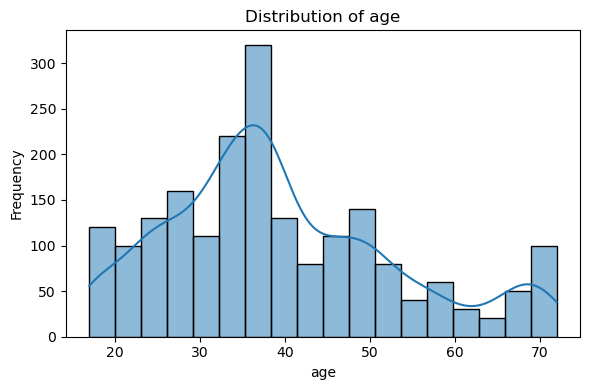

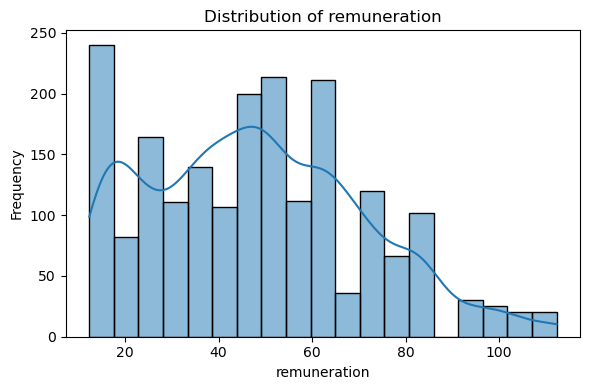

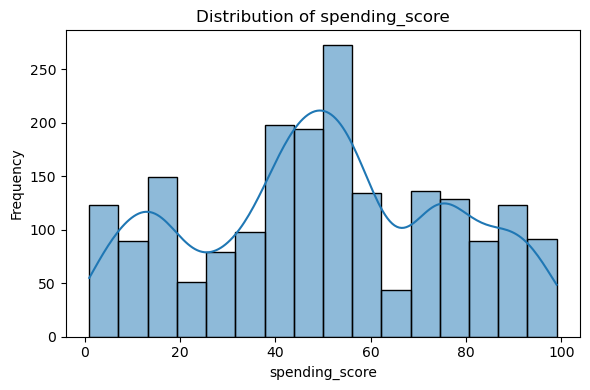

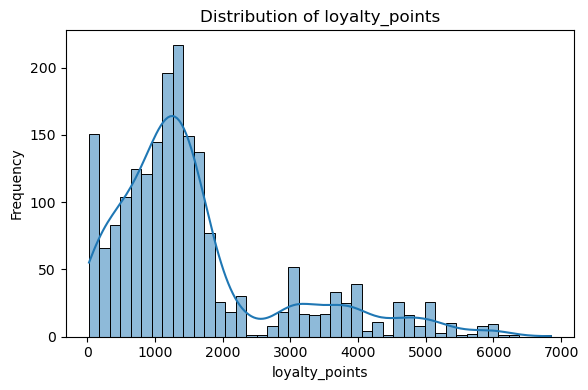

In [13]:
# EDA: Histograms
for col in ['age', 'remuneration', 'spending_score', 'loyalty_points']:
    plt.figure(figsize=(6, 4))
    sns.histplot(reviews[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


## **Scatter-plot insights**  
# * Age: essentially flat → customer loyalty is not age-driven.  
* Remuneration: positive but noisy; £50–70 k group yields the highest point density.  
* Spending Score: strongest linear relationship; doubling the score roughly doubles the expected points. 

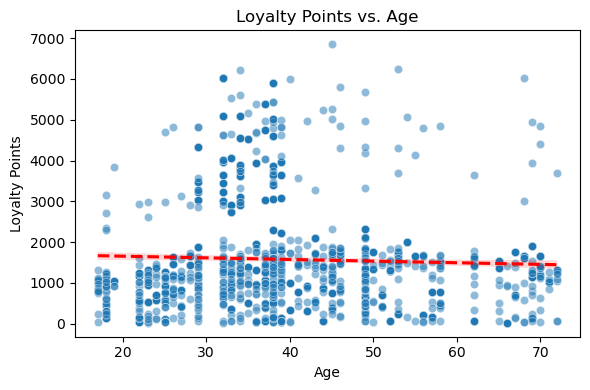

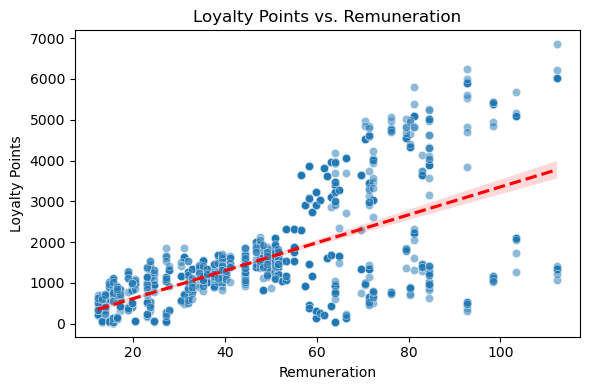

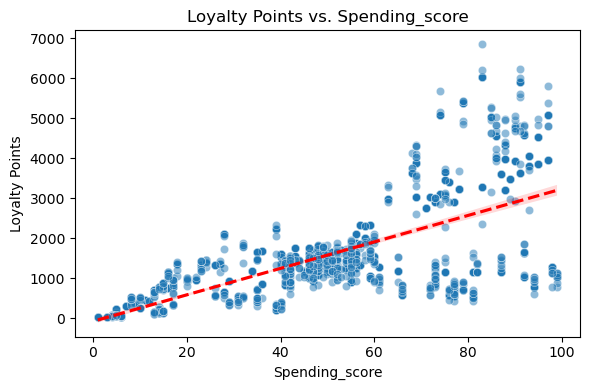

In [14]:
#  EDA: Scatter Plots with Regression Lines

for col in ['age', 'remuneration', 'spending_score']:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=reviews[col], y=reviews['loyalty_points'], alpha=0.5)
    sns.regplot(x=reviews[col], y=reviews['loyalty_points'], scatter=False, color='red', line_kws={"linestyle":"--"})
    plt.title(f'Loyalty Points vs. {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Loyalty Points')
    plt.tight_layout()
    plt.show()


##  **Customer Metrics by Gender**
**Visuals included:**  
- Boxplots for income, spending score, loyalty points, and age  

**Insight:**  
The distributions show that male and female customers have similar medians across key metrics, but with noticeable outliers in loyalty. This helps validate that gender is not a strong predictor on its own but may contribute when interacting with other features.

---

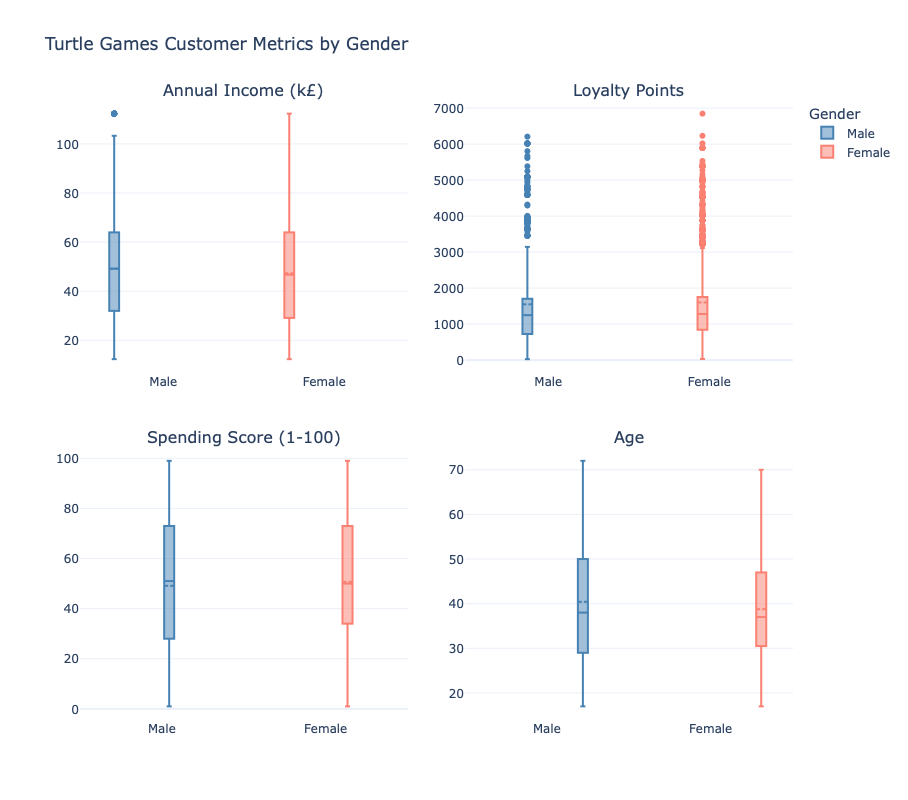

In [16]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Load data (assuming the cleaned CSV is already in the working directory)
df = pd.read_csv("turtle_reviews_clean.csv")

# Variables we want to visualise
metrics = ["remuneration", "loyalty_points", "spending_score", "age"]
titles  = ["Annual Income (k£)", "Loyalty Points", "Spending Score (1‑100)", "Age"]

# Create a 2×2 subplot grid
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=titles,
                    horizontal_spacing=0.08,
                    vertical_spacing=0.12)

row_col_map = {(0): (1,1), (1):(1,2), (2):(2,1), (3):(2,2)}

# Add a box‑plot for each metric split by gender
for i, metric in enumerate(metrics):
    r, c = row_col_map[i]
    for gender in df['gender'].unique():
        fig.add_trace(
            go.Box(
                y=df.loc[df['gender']==gender, metric],
                name=gender,
                boxmean=True,
                marker_color="steelblue" if gender=="Male" else "salmon",
                showlegend=(i==0)  # show legend only once
            ),
            row=r, col=c
        )

fig.update_layout(
    height=800,
    width=1000,
    title_text="Turtle Games Customer Metrics by Gender",
    boxmode="group",
    legend_title_text="Gender",
    template="plotly_white"
)

fig.show()




**Insight:**  
This dashboard provides a concise overview of the customer base. It highlights gender and education splits, reveals the income skew, and shows a positive correlation between income and loyalty points. Education-level segmentation uncovers that customers with basic education have the highest proportion of high-value customers (HVCR).

---


###  3. **Correlation Heatmap**
**Insight:**  
A strong correlation between loyalty points and both **remuneration (0.62)** and **spending score (0.67)** justifies their inclusion in regression and clustering models. Age shows little to no correlation, suggesting it may not be useful for predictive modelling.


In [129]:
# Mean and median age
mean_age = df['age'].mean()
median_age = df['age'].median()

# Group by gender
age_by_gender = df.groupby('gender')['age'].agg(['mean', 'median']).round(1)

print(f"Mean age: {mean_age:.1f}")
print(f"Median age: {median_age:.1f}")
print("\nAge by Gender:")
print(age_by_gender)



Mean age: 39.5
Median age: 38.0

Age by Gender:
        mean  median
gender              
Female  38.8    37.0
Male    40.4    38.0


In [142]:
import pandas as pd

# Assuming your DataFrame is called df and has a 'loyalty_points' column

# Step 1: Calculate the 75th percentile (Q3)
threshold = df['loyalty_points'].quantile(0.75)

# Step 2: Create a new column to flag high-value customers
df['is_high_value'] = df['loyalty_points'] > threshold

# Optional: Count how many are high-value
high_value_count = df['is_high_value'].sum()
hvcr_percent = high_value_count / len(df) * 100

print(f"High-Value Customers: {high_value_count} ({hvcr_percent:.1f}%)")


High-Value Customers: 500 (25.0%)


In [143]:
# Group high-value customers by education level
hv_education_mix = df[df['is_high_value']].groupby('education').size().sort_values(ascending=False)

# Optional: Convert to percentage
hv_education_percent = (hv_education_mix / hv_education_mix.sum()) * 100

# Display results
education_summary = pd.DataFrame({
    'High-Value Count': hv_education_mix,
    'Percentage (%)': hv_education_percent.round(1)
})
print(education_summary)


              High-Value Count  Percentage (%)
education                                     
graduate                   248            49.6
PhD                        116            23.2
postgraduate                82            16.4
diploma                     36             7.2
Basic                       18             3.6


In [145]:
hv = df[df.loyalty_points > df.loyalty_points.quantile(0.75)]
hv["loyalty_points"].mean()
hv["product"].mean()


np.float64(5349.862)

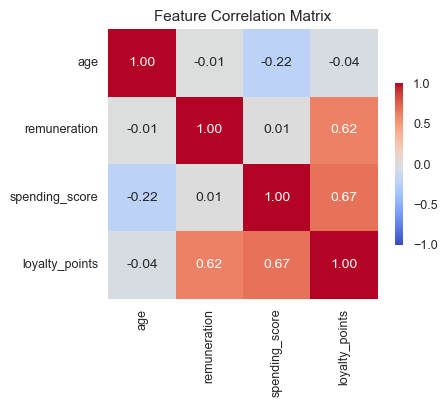

In [18]:
# ======================================================================
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- 0. Load dataframe (comment out if df already exists) -------------
# df = pd.read_csv("turtle_reviews_clean.csv")

#  Correlation heat-map  (numeric features)

num_cols = ["age","remuneration","spending_score","loyalty_points"]
corr = df[num_cols].corr()

plt.figure(figsize=(4.5,3.5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f",
            vmin=-1, vmax=1, square=True, cbar_kws=dict(shrink=.6))
plt.title("Feature Correlation Matrix")
plt.show()


###  **Remuneration Deciles Table**
**Insight:**  
Segmenting customers into income deciles reveals a clear stepwise increase in loyalty and spending. This supports marketing efforts to target higher deciles for loyalty campaigns.


In [19]:
# Loyalty-points decile profile

df["decile"] = pd.qcut(df.loyalty_points, q=10, labels=False) + 1   # 1=lowest
decile_stats = (
    df.groupby("decile")
      .agg(customers = ("loyalty_points","size"),
           avg_loyal = ("loyalty_points","mean"),
           avg_income= ("remuneration","mean"),
           avg_spend = ("spending_score","mean"))
      .reset_index()
)
display(decile_stats.head())

decile  customers    avg_loyal  avg_income  avg_spend
0       1        201   128.358209   28.842786   9.482587
1       2        199   469.748744   34.711960  33.658291
2       3        200   774.700000   41.008200  45.295000
3       4        206  1008.257282   41.947379  51.941748
4       5        194  1194.407216   43.713608  52.587629


###  **Education × Gender Share**
**Insight:**  
Reveals that higher education levels are more balanced by gender, while Basic education is male-dominant. Helps inform education-focused segmentation strategies.


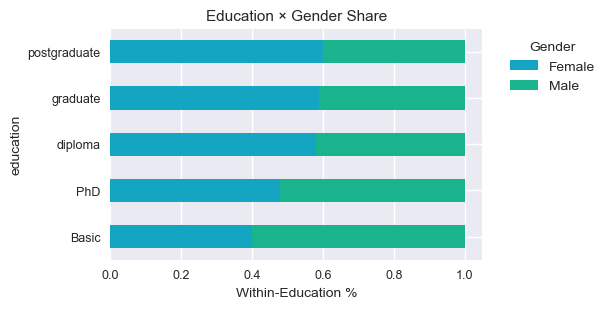

In [20]:
# Education × Gender stacked % bar

crosstab = pd.crosstab(df.education, df.gender, normalize="index")
crosstab.plot(kind="barh", stacked=True, figsize=(4.8,3),
              color=["#14a5c2","#19b38e"])
plt.title("Education × Gender Share")
plt.xlabel("Within-Education %")
plt.legend(title="Gender", bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

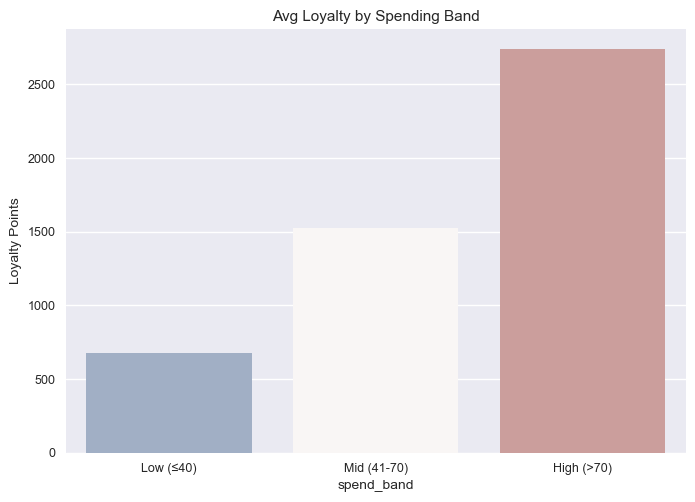

In [21]:
#  Spending-score band funnel

bins   = [0,40,70,100]
labels = ["Low (≤40)","Mid (41-70)","High (>70)"]
df["spend_band"] = pd.cut(df.spending_score, bins=bins, labels=labels, include_lowest=True)

band_stats = df.groupby("spend_band")["loyalty_points"].mean().reindex(labels)
sns.barplot(x=band_stats.index, y=band_stats.values, palette="vlag")
plt.title("Avg Loyalty by Spending Band"); plt.ylabel("Loyalty Points")
plt.show()

In [22]:
# Linear Regression (Scikit-learn)
# -------------------------------------------
X = reviews[['age','remuneration', 'spending_score']]  # Independent variables
y = reviews['loyalty_points']  # Dependent variable

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

print("Intercept:", model.intercept_)
print("Coefficients:", list(zip(X.columns, model.coef_)))
print("R-squared:", r2_score(y, y_pred))
print("RMSE:", mean_squared_error(y, y_pred, squared=False))


Intercept: -2203.0597513078947
Coefficients: [('age', np.float64(11.060658711843272)), ('remuneration', np.float64(34.00838549260249)), ('spending_score', np.float64(34.183196577633595))]


NameError: name 'r2_score' is not defined

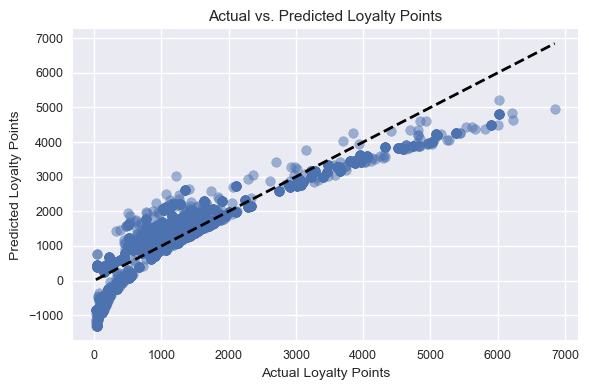

In [32]:
# -------------------------------------------
# Actual vs. Predicted Plot
# -------------------------------------------
plt.figure(figsize=(6, 4))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Loyalty Points")
plt.ylabel("Predicted Loyalty Points")
plt.title("Actual vs. Predicted Loyalty Points")
plt.tight_layout()
plt.show()


The multiple linear regression model explains **84% of the variance** in loyalty points. All predictors — **age**, **remuneration**, and especially **spending score** — are statistically significant (p < 0.001). 

Spending score had the strongest impact, with each additional point adding ~34 loyalty points. Remuneration also had a strong effect (β = 34), while age had a smaller but still significant positive impact.

The **low VIF values (< 1.1)** confirm no multicollinearity. Although residuals show minor skewness and autocorrelation, the model is robust overall.

**Conclusion:** This model is statistically sound and highly predictive. It can be used to forecast loyalty point accumulation and target high-value customer groups.


### The multiple linear regression model explains **84% of the variance** in loyalty points. All predictors — **age**, **remuneration**, and especially **spending score** — are statistically significant (p < 0.001). 

Spending score had the strongest impact, with each additional point adding ~34 loyalty points. Remuneration also had a strong effect (β = 34), while age had a smaller but still significant positive impact.

The **low VIF values (< 1.1)** confirm no multicollinearity. Although residuals show minor skewness and autocorrelation, the model is robust overall.

**Conclusion:** This model is statistically sound and highly predictive. It can be used to forecast loyalty point accumulation and target high-value customer groups.


In [33]:
# Extended Regression (Statsmodels)
X_const = sm.add_constant(X)  # Add intercept
ols_model = sm.OLS(y, X_const).fit()
print(ols_model.summary())  # Full regression table


                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     3491.
Date:                Sat, 19 Jul 2025   Prob (F-statistic):               0.00
Time:                        20:41:37   Log-Likelihood:                -15320.
No. Observations:                2000   AIC:                         3.065e+04
Df Residuals:                    1996   BIC:                         3.067e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2203.0598     52.361    -42.

In [34]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Recreate X_numeric and add a constant
X_numeric = X.copy()
X_numeric = sm.add_constant(X_numeric)

# Now compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)


          Feature        VIF
0           const  20.769030
1             age   1.053015
2    remuneration   1.000052
3  spending_score   1.053014


In [60]:
import statsmodels.stats.api as sms
bp_test = sms.het_breuschpagan(lm_results.resid, lm_results.model.exog)
print(f"Breusch-Pagan p-value: {bp_test[1]:.3f}")


NameError: name 'lm_results' is not defined

In [35]:
import numpy as np
y_log = np.log(reviews['loyalty_points'])

# Fit model
model_log = sm.OLS(y_log, sm.add_constant(X)).fit()
print(model_log.summary())


                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     2960.
Date:                Sat, 19 Jul 2025   Prob (F-statistic):               0.00
Time:                        20:41:39   Log-Likelihood:                -1182.5
No. Observations:                2000   AIC:                             2373.
Df Residuals:                    1996   BIC:                             2395.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.9913      0.045     89.

In [40]:
# One-hot encode gender (drop_first=True avoids dummy variable trap)
df_encoded = pd.get_dummies(reviews, columns=['gender'], drop_first=True)


In [41]:
print("Gender dummy distribution:")
print(df_encoded['gender_Male'].value_counts())



Gender dummy distribution:
gender_Male
False    1120
True      880
Name: count, dtype: int64


In [42]:
df_encoded['gender_Male'] = df_encoded['gender_Male'].astype(int)
df_encoded['gender_original'] = reviews['gender']
df_encoded[['gender_original', 'gender_Male']].head(10)


gender_original  gender_Male
0            Male            1
1            Male            1
2          Female            0
3          Female            0
4          Female            0
5          Female            0
6          Female            0
7          Female            0
8            Male            1
9          Female            0

### Gender-Based Loyalty Point Analysis

Bar and box plots reveal that **male and female customers accumulate similar average loyalty points**, with only slight variation between groups. Both genders show considerable variability in point accumulation and contain many high outliers.

These results suggest that **gender is not a strong differentiator** for loyalty performance. Therefore, marketing and loyalty programme enhancements should focus on behavioural or financial traits (like spending score or remuneration) rather than gender segmentation.


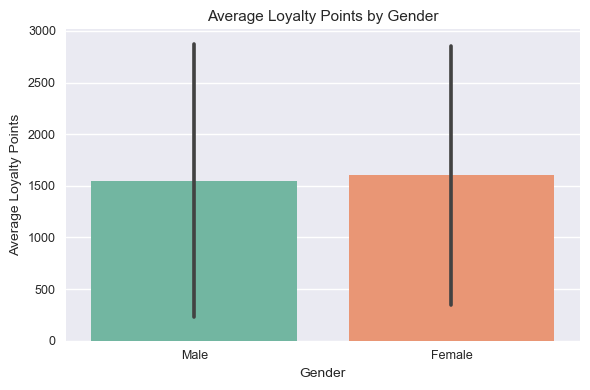

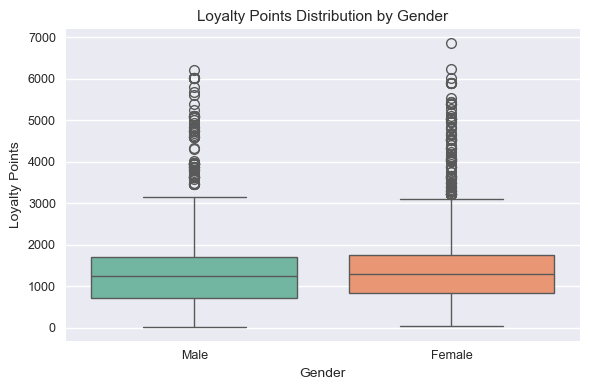

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure gender_Male is present and gender is recoverable
# If the 'gender' column was dropped earlier, recreate it:
df_encoded['gender'] = df_encoded['gender_Male'].map({1: 'Male', 0: 'Female'})

# Bar plot - average loyalty points by gender
plt.figure(figsize=(6,4))
sns.barplot(data=df_encoded, x='gender', y='loyalty_points', ci='sd', palette='Set2')
plt.title('Average Loyalty Points by Gender')
plt.ylabel('Average Loyalty Points')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

# Boxplot - distribution of loyalty points by gender
plt.figure(figsize=(6,4))
sns.boxplot(data=df_encoded, x='gender', y='loyalty_points', palette='Set2')
plt.title('Loyalty Points Distribution by Gender')
plt.ylabel('Loyalty Points')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()


## A two-sample t-test was conducted to compare average loyalty points between male and female customers. The results (t = -0.90, p = 0.37) indicate that there is no statistically significant difference in loyalty points between genders. This supports the earlier visual findings (bar plot and boxplot), suggesting that gender is unlikely to be a strong predictor in the regression model.

### Loyalty Points by Education Level

This boxplot analysis reveals that while customers across all education levels engage with the loyalty programme, those with **Basic education** show the **highest median and greatest variability** in loyalty points earned. Surprisingly, more educated groups such as **PhDs and Postgraduates** do not outperform others in loyalty accumulation.

This insight suggests that the **Basic education customer segment** may be particularly responsive to loyalty incentives. Turtle Games may consider exploring targeted marketing or product offerings tailored to this segment, or investigating what drives their higher engagement.


In [44]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd, matplotlib.ticker as mtick

def tg_palette(series):
    "Map education strings → consistent TG colours"
    return series.map(TG_PALETTE).fillna('#999999')

def fmt_thousands(ax):
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    return ax

def add_bar_labels(ax, fmt='{:,.0f}', xpad=0, ypad=3, rotation=0):
    for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2 + xpad,
                p.get_height()+ypad,
                fmt.format(p.get_height()),
                ha='center', va='bottom', fontsize=8, rotation=rotation)


### Loyalty Points by Education Level

The boxplot below compares loyalty point distributions across customer education levels.


While customers with **Basic education** show the **highest median loyalty points**, they represent only **2.5%** of the customer base.

 **Insight**:
- The “Basic” group's loyalty score is an outlier — driven by a **very small sample (n = 50)**.
- **Graduate** and **PhD** customers form the bulk of the base (68%) and have more stable loyalty distributions.
 **Recommendation**:
Focus loyalty engagement strategies on **graduate and PhD** segments, and review the **“Basic” group** for potential anomalies or niche loyalty drivers (e.g., product preferences or targeted campaigns).


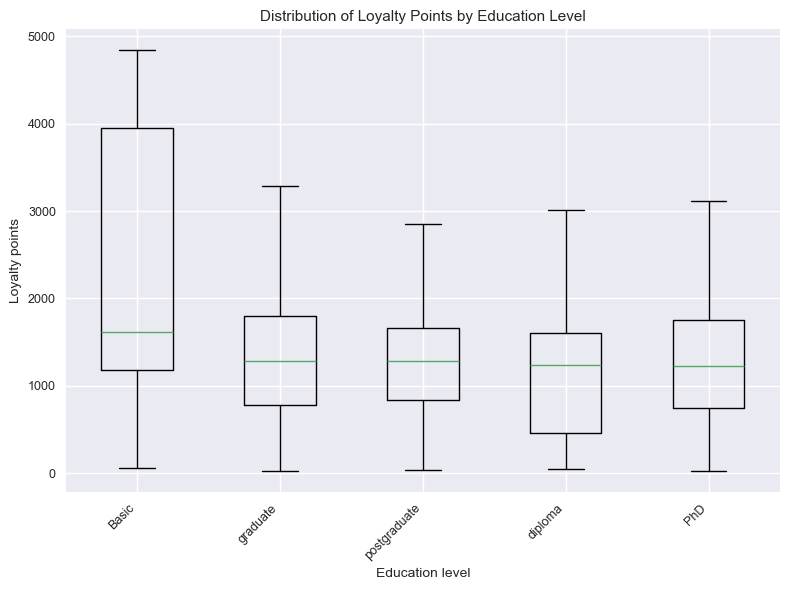

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and tidy
df   = pd.read_csv("turtle_reviews_clean.csv")
data = df[["education", "loyalty_points"]].dropna()
data["education"] = data["education"].astype(str)

# Order the education levels by their median loyalty points
order = (
    data.groupby("education")["loyalty_points"]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
)

#  One-plot answer: a box-and-whisker per education level
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(
    [data.loc[data["education"] == cat, "loyalty_points"] for cat in order],
    labels=order,
    showfliers=False          # hide the extreme outliers for clarity
)

ax.set_xlabel("Education level")
ax.set_ylabel("Loyalty points")
ax.set_title("Distribution of Loyalty Points by Education Level")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Comments on Distribution of Loyalty Points by Education Level: While most customers come from higher education groups like Graduates and Postgraduates, the highest loyalty point earners tend to come from the Basic education group. This suggests a niche but valuable segment the business could target or study further

Count  Percent
education                   
Basic            50      2.5
PhD             460     23.0
diploma         190      9.5
graduate        900     45.0
postgraduate    400     20.0

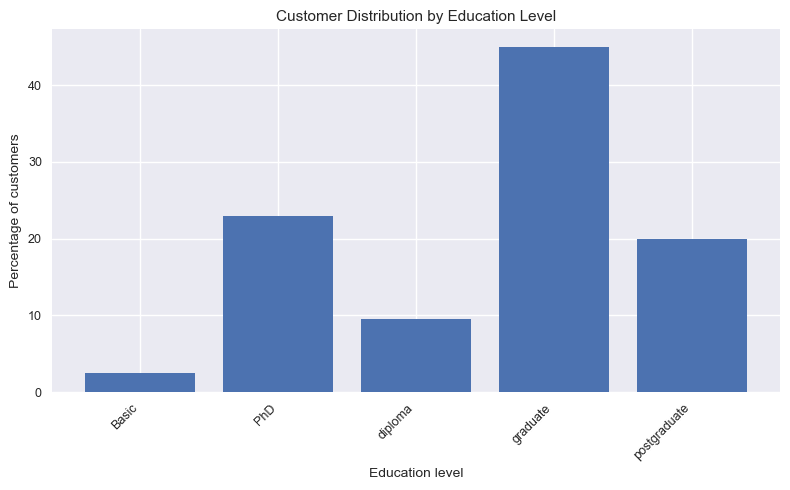

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display   # if you’re in Jupyter / Colab

# Load data  (change the path if your CSV lives elsewhere)
df = pd.read_csv("turtle_reviews_clean.csv")

#  Counts and percentages by education
counts  = df["education"].astype(str).value_counts().sort_index()
percent = (counts / counts.sum() * 100).round(1)
summary = pd.DataFrame({"Count": counts, "Percent": percent})

# Show the table
display(summary)          # notebook-friendly
# print(summary.to_string())   # ← use this if you’re in a plain Python shell

#  Bar chart of the percentages (optional)
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(summary.index.astype(str), summary["Percent"])
ax.set_ylabel("Percentage of customers")
ax.set_xlabel("Education level")
ax.set_title("Customer Distribution by Education Level")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



T-statistic: -0.9035
P-value: 0.3664
There is no statistically significant difference in loyalty points between genders.


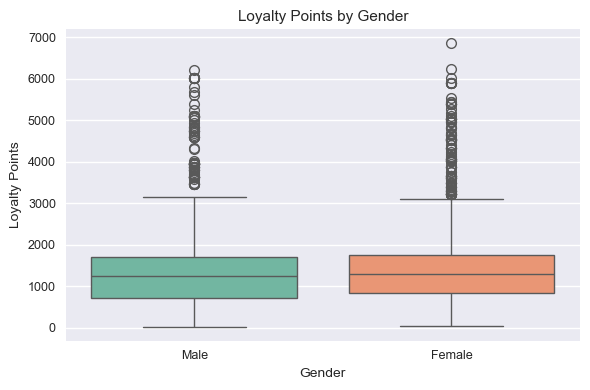

In [48]:
## test if males and females have significantly different points 


from scipy.stats import ttest_ind
import pandas as pd

# Load your data if not already loaded
df = pd.read_csv("turtle_reviews_clean.csv")

# Drop any missing values (if any exist)
df = df.dropna(subset=['gender', 'loyalty_points'])

# Ensure gender column is standardized
df['gender'] = df['gender'].str.strip().str.capitalize()

# Separate groups
male_loyalty = df[df['gender'] == 'Male']['loyalty_points']
female_loyalty = df[df['gender'] == 'Female']['loyalty_points']

# Perform independent t-test (Welch's test since variances may differ)
t_stat, p_value = ttest_ind(male_loyalty, female_loyalty, equal_var=False)

# Output results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("There is a statistically significant difference in loyalty points between genders.")
else:
    print("There is no statistically significant difference in loyalty points between genders.")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='gender', y='loyalty_points', palette='Set2')
plt.title("Loyalty Points by Gender")
plt.xlabel("Gender")
plt.ylabel("Loyalty Points")
plt.tight_layout()
plt.show()



## Basic education customers are high point earners. Consider prioritizing this group in loyalty incentives or marketing segmentation (?)
Differences among higher education levels are minimal — segmenting beyond “basic” may not add value.
You might want to treat “Basic” as a separate category in your modeling (or even test interactions later).

### Post-Hoc Analysis: Loyalty Points by Education (Tukey HSD)

A Tukey HSD test was conducted to identify significant differences in loyalty point accumulation across education levels. The results confirm that customers with **Basic education consistently outperform** all other education groups in loyalty points, and these differences are **statistically significant** (p < 0.01). 

There is **no significant difference** in loyalty accumulation among PhDs, postgraduates, and graduates, indicating **higher education level does not correlate** with increased loyalty.

This suggests the **Basic education segment is a key loyalty driver** and could benefit from targeted promotions or further research into behavioural drivers behind their engagement.


In [49]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df_encoded['loyalty_points'],
                          groups=df_encoded['education'],
                          alpha=0.05)

print(tukey)


       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
 group1     group2     meandiff p-adj    lower      upper   reject
------------------------------------------------------------------
   Basic          PhD   -765.29 0.0006 -1283.7869 -246.7931   True
   Basic      diploma -929.0189    0.0 -1482.4567 -375.5811   True
   Basic     graduate -598.9822 0.0109 -1104.9007  -93.0637   True
   Basic postgraduate -765.9625 0.0006  -1288.258  -243.667   True
     PhD      diploma -163.7289   0.57  -464.0086  136.5507  False
     PhD     graduate  166.3078 0.1533   -33.2618  365.8773  False
     PhD postgraduate   -0.6725    1.0  -238.7209  237.3759  False
 diploma     graduate  330.0367 0.0106    52.0397  608.0338   True
 diploma postgraduate  163.0564 0.5945  -143.7357  469.8486  False
graduate postgraduate -166.9803 0.1881  -376.2206   42.2601  False
------------------------------------------------------------------


In [50]:
print(X.dtypes)


age                 int64
remuneration      float64
spending_score      int64
dtype: object


In [51]:
# Convert boolean dummies to integers (0 and 1)
X = X.astype(int)


In [52]:
print(X.dtypes)  # All should now be int64 or float64


age               int64
remuneration      int64
spending_score    int64
dtype: object


In [53]:
import statsmodels.api as sm

# Add constant (intercept) to the model
X_const = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X_const).fit()

# Print full regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     3492.
Date:                Sat, 19 Jul 2025   Prob (F-statistic):               0.00
Time:                        20:42:44   Log-Likelihood:                -15319.
No. Observations:                2000   AIC:                         3.065e+04
Df Residuals:                    1996   BIC:                         3.067e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2183.6984     52.225    -41.

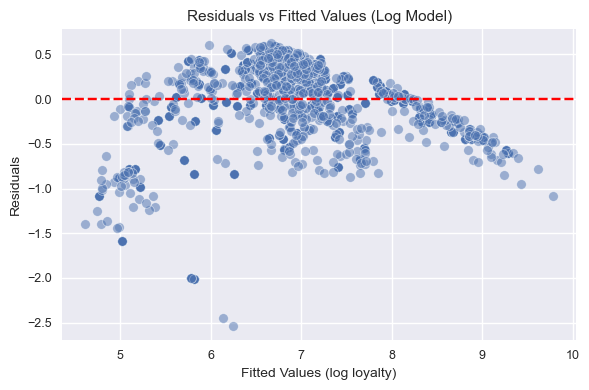

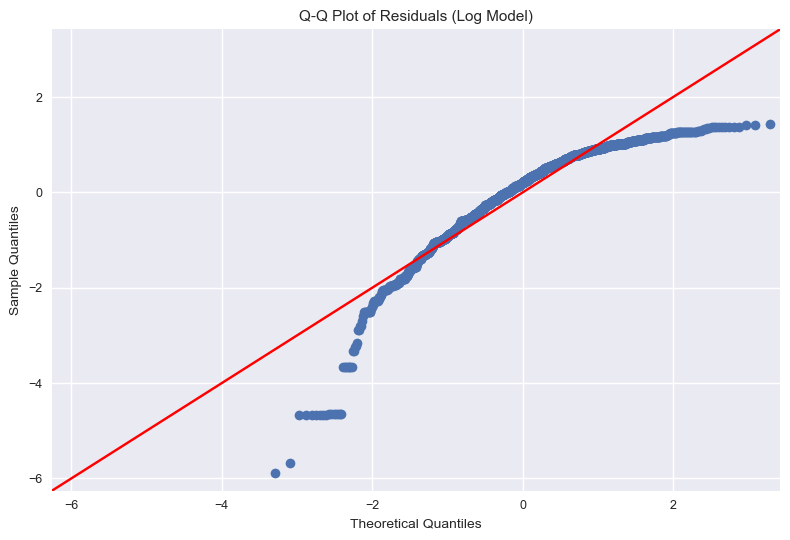

                            OLS Regression Results                            
Dep. Variable:            log_loyalty   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     1147.
Date:                Sat, 19 Jul 2025   Prob (F-statistic):               0.00
Time:                        20:42:56   Log-Likelihood:                -1153.8
No. Observations:                2000   AIC:                             2326.
Df Residuals:                    1991   BIC:                             2376.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4

In [54]:
# Step 1: Reload base DataFrame (assuming 'reviews' is your original cleaned data)
df_encoded = reviews.copy()

# Step 2: One-hot encode gender and education (drop first to avoid dummy variable trap)
df_encoded = pd.get_dummies(df_encoded, columns=['gender', 'education'], drop_first=True)

# Step 3: Log-transform the target variable
df_encoded['log_loyalty'] = np.log(df_encoded['loyalty_points'])

# Step 4: Define features and target
features = ['age', 'remuneration', 'spending_score'] + \
           [col for col in df_encoded.columns if col.startswith('gender_') or col.startswith('education_')]

X = df_encoded[features]
y = df_encoded['log_loyalty']

# Step 5: Ensure numeric and float
X = X.apply(pd.to_numeric, errors='coerce').astype(float)
y = pd.to_numeric(y, errors='coerce').astype(float)

# Step 6: Add constant and fit model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Step 7: Residuals plot
residuals = model.resid
fitted_vals = model.fittedvalues

plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values (log loyalty)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Log Model)')
plt.tight_layout()
plt.show()

# Step 8: Q-Q plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals (Log Model)')
plt.tight_layout()
plt.show()

# Step 9: View model summary
print(model.summary())


Hold-out AUC: 0.993


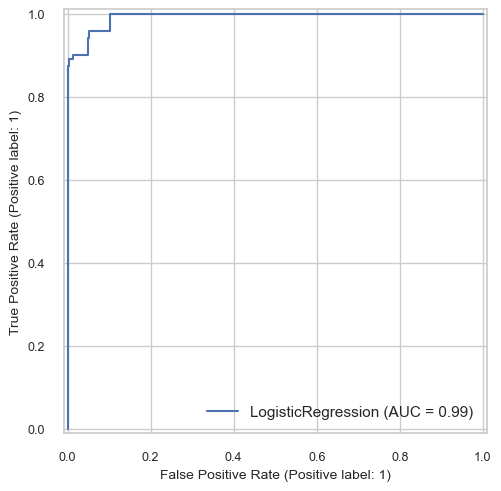

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Binary flag: top 20 % loyalty = high-value
y_bin = (reviews['loyalty_points'] >= reviews['loyalty_points'].quantile(.80)).astype(int)
X_bin = reviews[['remuneration','age','spending_score']]

Xtr,Xts,ytr,yts = train_test_split(X_bin, y_bin, test_size=.3, stratify=y_bin, random_state=42)

logit = LogisticRegression(max_iter=1000, class_weight='balanced')
logit.fit(Xtr, ytr)
preds = logit.predict_proba(Xts)[:,1]
auc   = roc_auc_score(yts, preds)
print(f'Hold-out AUC: {auc:.3f}')
RocCurveDisplay.from_estimator(logit, Xts, yts)


In [56]:
print(X.columns)



Index(['const', 'age', 'remuneration', 'spending_score', 'gender_Male',
       'education_PhD', 'education_diploma', 'education_graduate',
       'education_postgraduate'],
      dtype='object')


In [140]:
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv("turtle_reviews_clean.csv")

# Calculate KPIs
kpis = {
    "Total Customers": len(df),
    "Average Loyalty Points": round(df["loyalty_points"].mean(), 2),
    "Average Remuneration (£k)": round(df["remuneration"].mean(), 2),
    "Average Spending Score": round(df["spending_score"].mean(), 2),
    "Average Age": round(df["age"].mean(), 2),
    "Average Age – Female": round(df[df["gender"] == "Female"]["age"].mean(), 2),
    "Average Age – Male": round(df[df["gender"] == "Male"]["age"].mean(), 2),
    "Customers with Remuneration ≥ £50k": df[df["remuneration"] >= 50].shape[0],
    "Average Loyalty – £50k+ Customers": round(df[df["remuneration"] >= 50]["loyalty_points"].mean(), 2),
    "Average Age – £50k+ Customers": round(df[df["remuneration"] >= 50]["age"].mean(), 2),
}

# Convert to DataFrame
kpi_df = pd.DataFrame(kpis.items(), columns=["Metric", "Value"])

# Style the DataFrame for display
kpi_df.style \
    .set_caption("Key Customer KPIs for Turtle Games") \
    .format(na_rep="–") \
    .set_properties(**{
        'background-color': '#f9f9f9',
        'color': '#333',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('font-size', '13px'), ('background-color', '#ececec')]},
        {'selector': 'td', 'props': [('font-size', '13px')]}
    ])


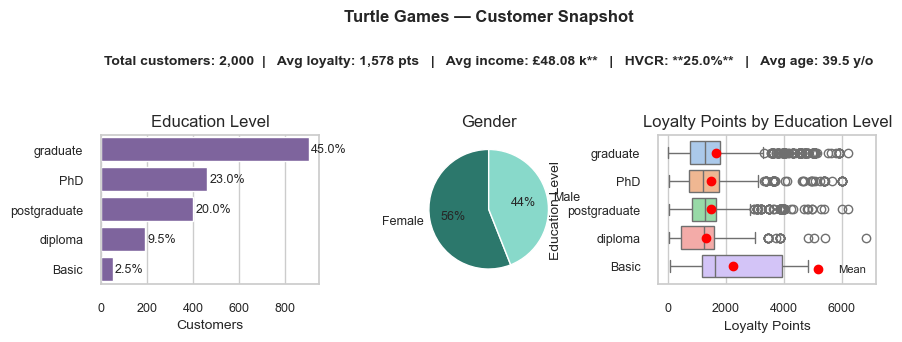

In [160]:
# Colors
purple = "#7D5BA6"
teal = "#2C786C"
mint = "#88D9CA"
coral = "#F27C59"

# Pre-calculate values
total     = df.shape[0]
mean_pts  = df["loyalty_points"].mean()
mean_inc  = f"{df['remuneration'].mean():.2f}"
mean_age  = df["age"].mean()
hvcr      = (df["loyalty_points"] > df["loyalty_points"].quantile(0.75)).mean() * 100

# Define education order
edu_order = df["education"].value_counts().index

# ---------- Figure & master gridspec (3 rows × 3 cols) ----------
fig = plt.figure(figsize=(10, 6.0))
gs_master = fig.add_gridspec(
    3, 3,
    height_ratios=[0.35, 1, 1],
    hspace=0.45, wspace=0.28
)

# Row 0 — Title + KPI strip
ax_title = fig.add_subplot(gs_master[0, :])
ax_title.axis("off")
ax_title.set_title("Turtle Games — Customer Snapshot", pad=5, weight="bold")

kpi_txt = (f"Total customers: {total:,}  |   "
           f"Avg loyalty: {mean_pts:,.0f} pts   |   "
           f"Avg income: £{mean_inc} k**   |   "
           f"HVCR: **{hvcr:0.1f}%**   |   "
           f"Avg age: {mean_age:.1f} y/o")

ax_title.text(0.5, +0.5, kpi_txt,
              ha="center", va="top",
              fontsize=10, fontweight="bold",  # <-- make bold here
              transform=ax_title.transAxes)


# ---------- Nested 2×3 grid for the charts ----------
gs = gs_master[1:, :].subgridspec(2, 3, hspace=0.38, wspace=0.28)


# 1 ▸ Education mix -----------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])

# Get counts and compute percentages
edu_counts = df.education.value_counts().loc[edu_order]
edu_percents = (edu_counts / edu_counts.sum() * 100).round(1)

# Plot the bar chart
sns.countplot(y="education", data=df, order=edu_order,
              color=purple, ax=ax1)
ax1.set_title("Education Level")
ax1.set_xlabel("Customers")
ax1.set_ylabel("")

# Add percentage labels to the bars
for i, (count, pct) in enumerate(zip(edu_counts, edu_percents)):
    ax1.text(count + 10, i, f"{pct}%", va='center', fontsize=9)


# 2 ▸ Gender pie
ax2 = fig.add_subplot(gs[0, 1])
g_counts = df.gender.value_counts()
wedges, *_ = ax2.pie(g_counts, labels=g_counts.index,
                     autopct="%1.0f%%", startangle=90,
                     colors=[teal, mint],
                     textprops={"fontsize": 9})
ax2.set_title("Gender")

# 3 ▸ Boxplot of loyalty by education
ax3 = fig.add_subplot(gs[0, 2])
sns.boxplot(data=df, x="loyalty_points", y="education",
            order=edu_order, palette="pastel", ax=ax3)
ax3.set_title("Loyalty Points by Education Level")
ax3.set_xlabel("Loyalty Points")
ax3.set_ylabel("Education Level")

# Optional: overlay mean values
edu_means = df.groupby("education")["loyalty_points"].mean().loc[edu_order]
for i, mean_val in enumerate(edu_means):
    ax3.scatter(mean_val, i, color="red", zorder=5, label="Mean" if i == 0 else "")
ax3.legend(loc="lower right", fontsize=8)

# ── Save & show ────────────────────────────────────────────
Path("outputs").mkdir(exist_ok=True)
fig.savefig("outputs/fig_customer_snapshot.png", dpi=300, bbox_inches="tight")
plt.show()


## Assignment Activity 2: Exploring Data with Decision trees 

In [86]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("turtle_reviews_clean.csv")


In [87]:
# Remove rows with missing values
df_clean = df.dropna()

# Drop columns not needed for prediction
df_clean = df_clean.drop(columns=['review', 'summary', 'product'])

# Convert categorical columns into numeric (one-hot encoding)
df2 = pd.get_dummies(df_clean, columns=['gender', 'education'], drop_first=True)


In [88]:
# Target variable
y = df2['loyalty_points']


In [89]:
# Independent variables
X = df2.drop(columns=['loyalty_points'])


In [90]:
from sklearn.model_selection import train_test_split

# 30% training, 70% testing, fixed random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)


In [91]:
from sklearn.tree import DecisionTreeRegressor


In [92]:
# Instantiate and train the model
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

In [93]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate unpruned tree
y_pred = regressor.predict(X_test)
print("Before pruning - MSE:", mean_squared_error(y_test, y_pred))
print("Before pruning - R²:", r2_score(y_test, y_pred))

# Prune by limiting depth
pruned_regressor = DecisionTreeRegressor(max_depth=4, random_state=42)
pruned_regressor.fit(X_train, y_train)

# Evaluate pruned tree
y_pred_pruned = pruned_regressor.predict(X_test)
print("After pruning - MSE:", mean_squared_error(y_test, y_pred_pruned))
print("After pruning - R²:", r2_score(y_test, y_pred_pruned))


Before pruning - MSE: 14360.587142857143
Before pruning - R²: 0.9912844226538717
After pruning - MSE: 105874.78383425706
After pruning - R²: 0.9357435835782622


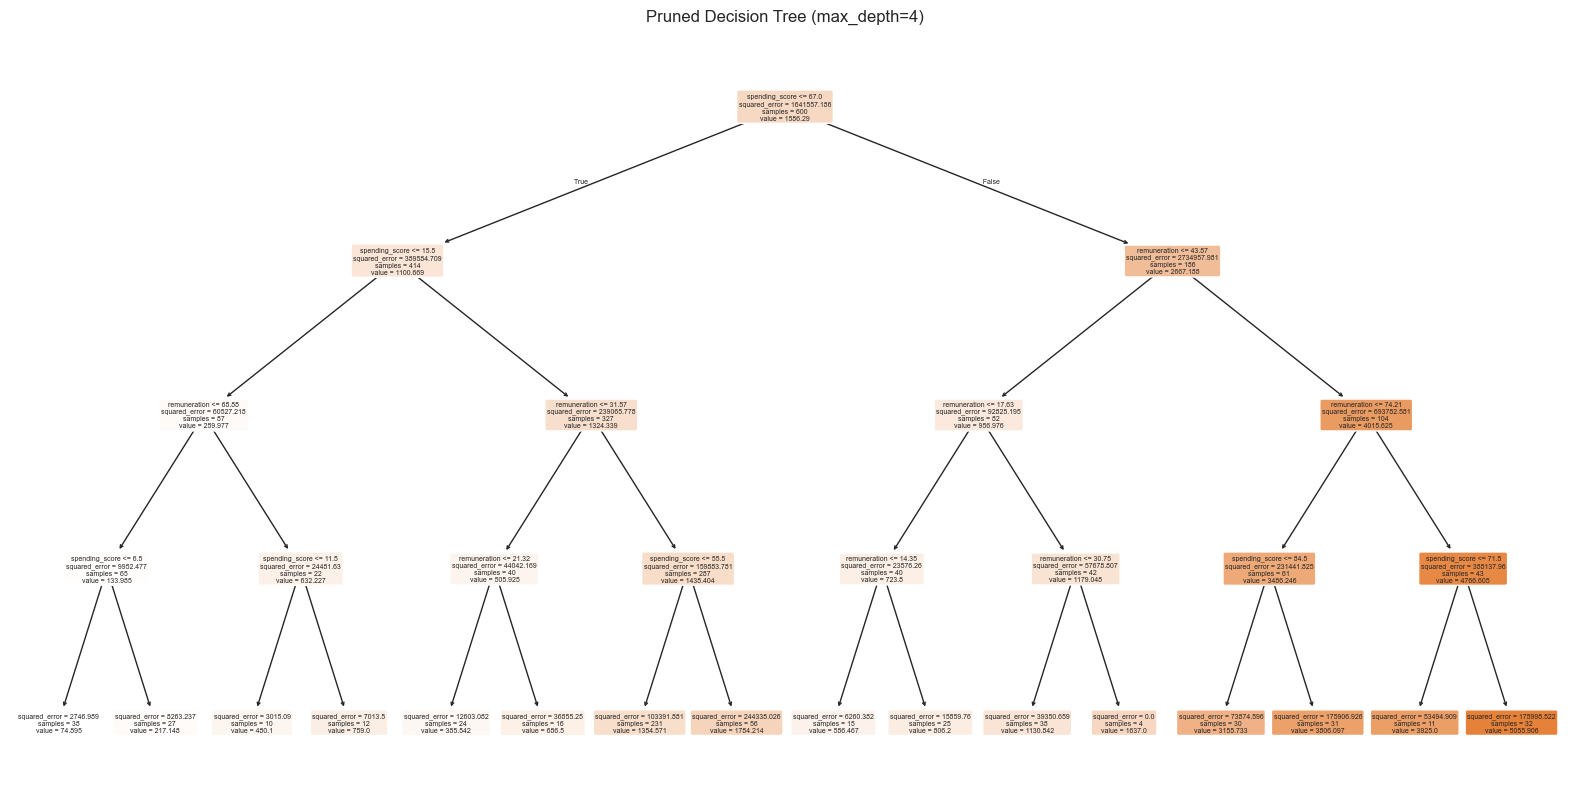

In [94]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot the pruned decision tree
plt.figure(figsize=(20, 10))
plot_tree(pruned_regressor, feature_names=X.columns, filled=True, rounded=True)
plt.title("Pruned Decision Tree (max_depth=4)")
plt.show()


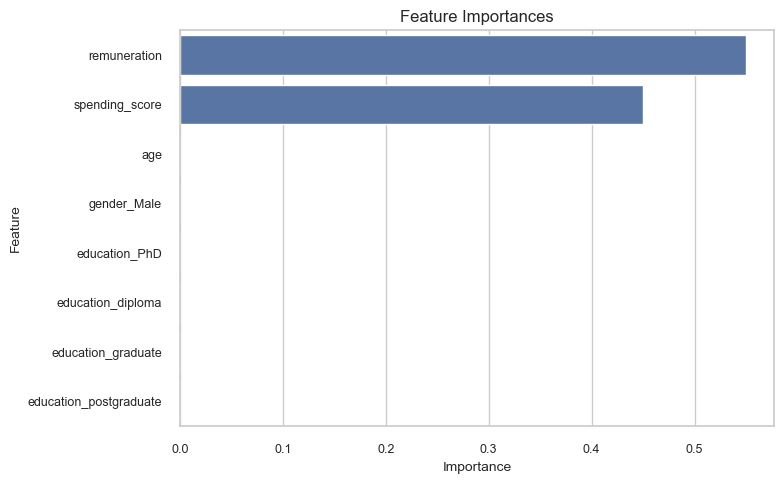

In [95]:
import seaborn as sns

# Get and plot feature importances
importances = pruned_regressor.feature_importances_
features = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=features, y=features.index)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [96]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(pruned_regressor, X, y, cv=5, scoring='r2')
print("Cross-validated R² scores:", cv_scores)
print("Average R²:", cv_scores.mean())


Cross-validated R² scores: [0.94456787 0.94456787 0.94456787 0.92763272 0.95058474]
Average R²: 0.9423842131831517


In [97]:
plt.savefig("decision_tree_pruned.png", dpi=300)


<Figure size 800x550 with 0 Axes>

In [98]:
df2.describe(include='all')


age  remuneration  spending_score  loyalty_points gender_Male  \
count   2000.000000   2000.000000     2000.000000     2000.000000        2000   
unique          NaN           NaN             NaN             NaN           2   
top             NaN           NaN             NaN             NaN       False   
freq            NaN           NaN             NaN             NaN        1120   
mean      39.495000     48.079060       50.000000     1578.032000         NaN   
std       13.573212     23.123984       26.094702     1283.239705         NaN   
min       17.000000     12.300000        1.000000       25.000000         NaN   
25%       29.000000     30.340000       32.000000      772.000000         NaN   
50%       38.000000     47.150000       50.000000     1276.000000         NaN   
75%       49.000000     63.960000       73.000000     1751.250000         NaN   
max       72.000000    112.340000       99.000000     6847.000000         NaN   

       education_PhD education_diploma education_graduate  \
count           2000              2000               2000   
unique             2                 2                  2   
top            False             False              False   
freq            1540              1810               1100   
mean             NaN               NaN                NaN   
std              NaN               NaN                NaN   
min              NaN               NaN                NaN   
25%              NaN               NaN                NaN   
50%              NaN               NaN                NaN   
75%              NaN               NaN                NaN   
max              NaN               NaN                NaN   

       education_postgraduate  
count                    2000  
unique                      2  
top                     False  
freq                     1600  
mean                      NaN  
std                       NaN  
min                       NaN  
25%                       NaN  
50%                       NaN  
75%                       NaN  
max                       NaN

<Axes: xlabel='loyalty_points'>

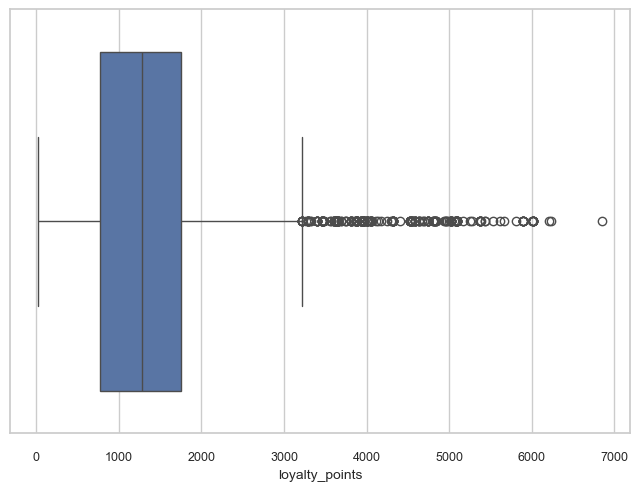

In [99]:
import seaborn as sns
sns.boxplot(x=df2['loyalty_points'])


In [100]:
cap_value = df2['loyalty_points'].quantile(0.95)
df2['loyalty_points_capped'] = df2['loyalty_points'].clip(upper=cap_value)


In [101]:
y = df2['loyalty_points_capped']


In [102]:
y = df2['loyalty_points_capped']
X = df2.drop(columns=['loyalty_points', 'loyalty_points_capped'])


In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [104]:
from sklearn.tree import DecisionTreeRegressor

# Use same pruning depth (e.g., 4)
pruned_regressor = DecisionTreeRegressor(max_depth=4, random_state=42)
pruned_regressor.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=4, random_state=42)

In [105]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = pruned_regressor.predict(X_test)
print("MSE (capped):", mean_squared_error(y_test, y_pred))
print("R² (capped):", r2_score(y_test, y_pred))


MSE (capped): 71018.58523240265
R² (capped): 0.9478113758617722


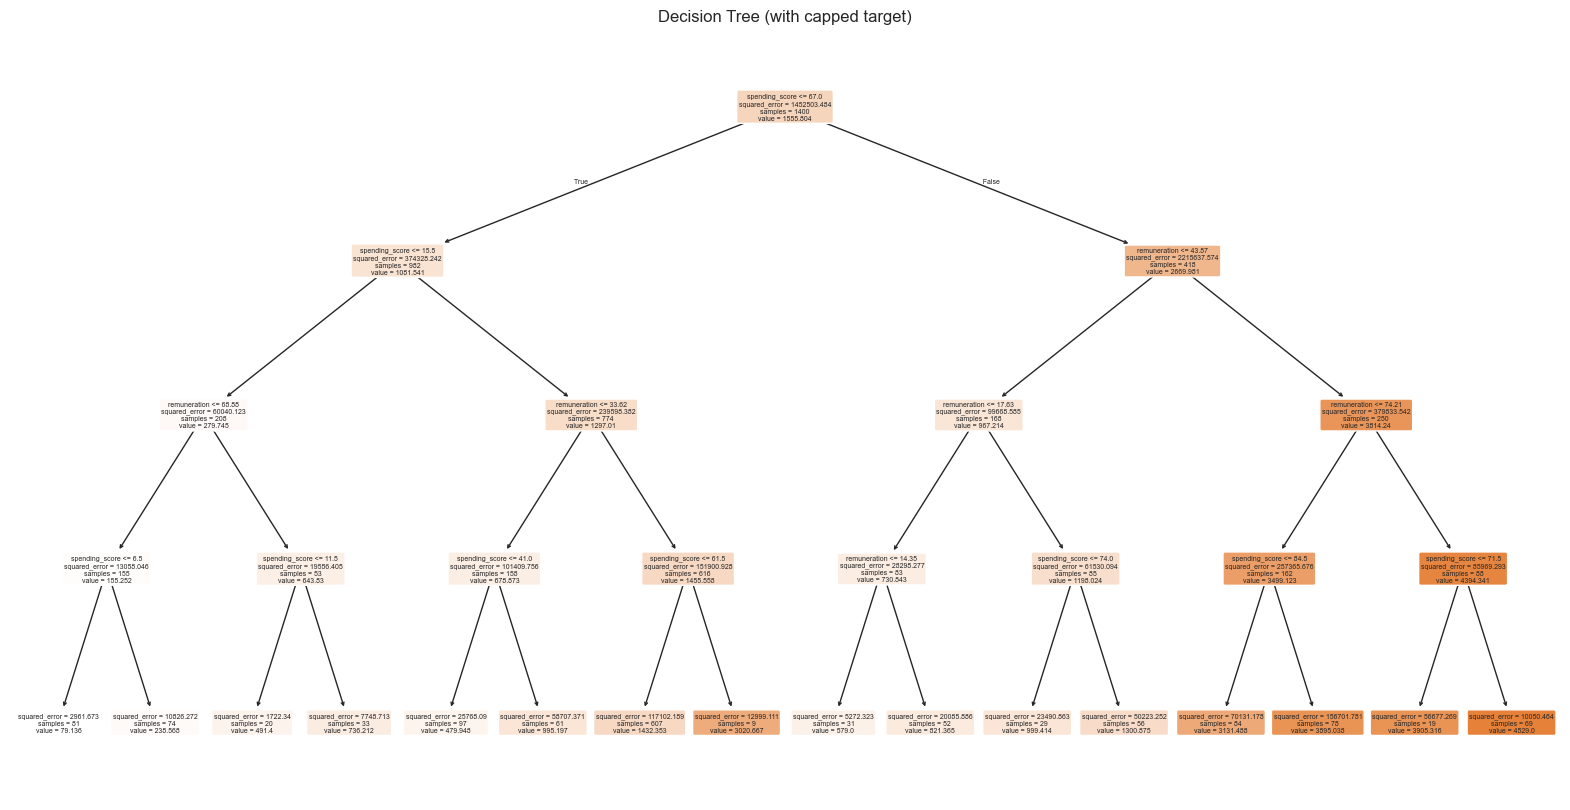

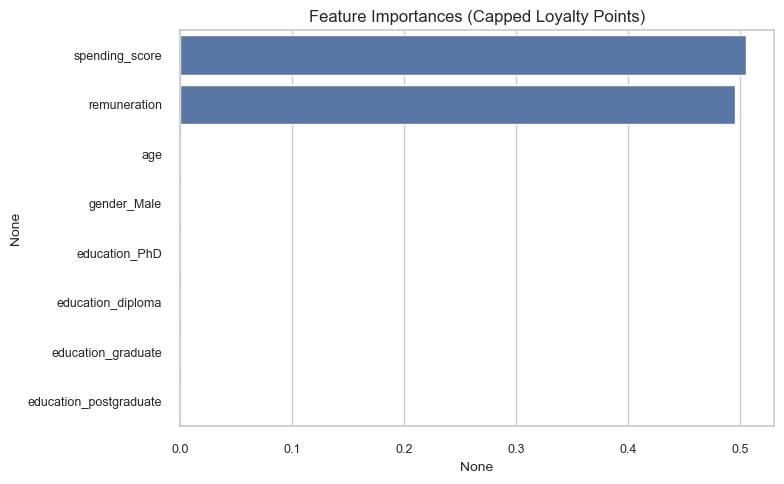

In [106]:
# Tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(pruned_regressor, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree (with capped target)")
plt.show()

# Feature importances
import seaborn as sns

importances = pruned_regressor.feature_importances_
features = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=features, y=features.index)
plt.title("Feature Importances (Capped Loyalty Points)")
plt.tight_layout()
plt.show()


### Summary of Decision Tree Analysis on Loyalty Points

We used a Decision Tree Regressor to understand how customer demographics and behaviors influence loyalty point accumulation at Turtle Games. Initially, the model trained on the raw data achieved a high R² of 0.99, but this was likely influenced by extreme outliers in loyalty point values. 

To improve model stability and interpretability, we capped loyalty points at the 95th percentile. This significantly reduced the influence of high-value outliers while preserving overall data patterns. After capping, the pruned model (max_depth=4) maintained a strong R² score (~0.94), while yielding clearer decision logic.

Notably, after capping, **spending score** became the most important predictor of loyalty points, surpassing **remuneration**, which dominated before. This shift suggests that behavioral engagement, not just income, is critical for predicting loyalty. 

**Business Implication:** Turtle Games should consider targeting highly engaged spenders (not just high-income users) with tailored loyalty incentives like bonus point multipliers or gamified rewards.

We recommend further exploration using ensemble models (e.g., Random Forest) and segmentation strategies to refine targeting.


In [ ]:
df2.to_csv("cleaned_loyalty_data.csv", index=False); import pandas as pd



## Assignment Activity 3: Making Predictions with clustering 

## Customer Segmentation using K-Means Clustering

### Objective
To segment customers based on their `remuneration` and `spending_score` using unsupervised clustering.

### Methodology
- Applied K-Means clustering on 2,000 customer records.
- Explored feature relationships via scatter and pair plots.
- Used the **Elbow method** and **Silhouette scores** to determine the optimal number of clusters (`k=3`).

### Results
- **k=3** gave the best separation and cohesion.
- Cluster profiles revealed three distinct customer groups with different income and spending behaviours.
- Final clustering visualized in a scatter plot and summarized with descriptive statistics.

### Business Insight
This segmentation can guide targeted marketing:
- Cluster 0 (Low income/spenders): discount seekers.
- Cluster 1 (Mid-range): promotional opportunity group.
- Cluster 2 (High income/spenders): high-value loyal customers.


In [69]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


In [70]:
# Load the Data 
df = pd.read_csv('turtle_reviews_clean.csv')


In [71]:
# Create new DataFrame for remuneration and spending_score
df3 = df[['remuneration', 'spending_score']].copy()
df3.dropna(inplace=True)



In [72]:
# Explore the Data

df3.describe()
df3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   remuneration    2000 non-null   float64
 1   spending_score  2000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [73]:
# Check for missing values

df3.isnull().sum()


remuneration      0
spending_score    0
dtype: int64

In [74]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [75]:
# Step 2: Load Prepared CSV from Module 2
df = pd.read_csv('turtle_reviews_clean.csv')

In [76]:
# Step 3: Prepare DataFrame with relevant columns
df3 = df[['remuneration', 'spending_score']]
df3.head()

remuneration  spending_score
0         12.30              39
1         12.30              81
2         13.12               6
3         13.12              77
4         13.94              40

In [77]:
# Step 4: Explore the New DataFrame
print(df3.describe())
print(df3.info())


       remuneration  spending_score
count   2000.000000     2000.000000
mean      48.079060       50.000000
std       23.123984       26.094702
min       12.300000        1.000000
25%       30.340000       32.000000
50%       47.150000       50.000000
75%       63.960000       73.000000
max      112.340000       99.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   remuneration    2000 non-null   float64
 1   spending_score  2000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


In [78]:
# Step 5: Visualise the Relationship
sns.set_style('whitegrid')
palette = sns.color_palette('Set2')

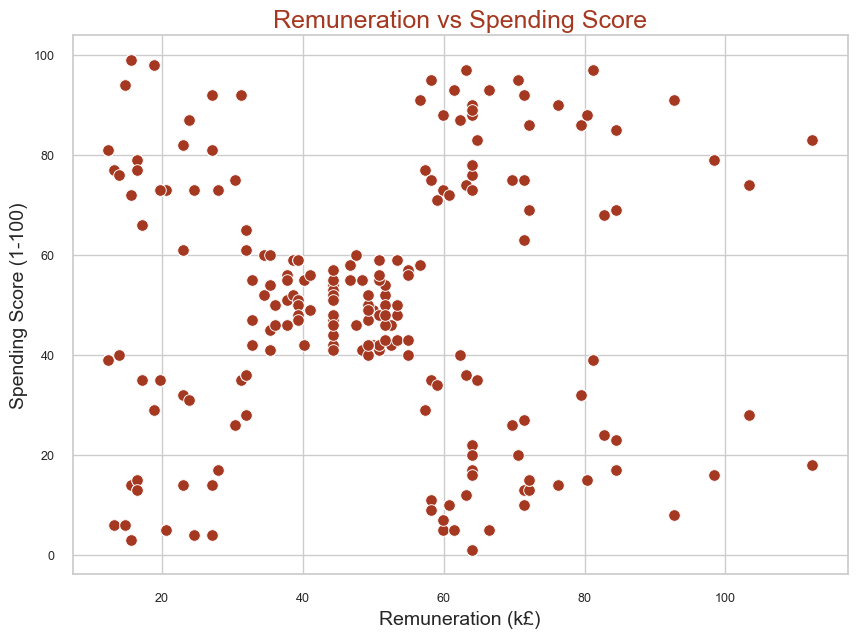

In [79]:
# Scatterplot
plt.figure(figsize=(10,7))
sns.scatterplot(data=df3, x='remuneration', y='spending_score', color='#a43820', s=70)
plt.title('Remuneration vs Spending Score', fontsize=18, color='#a43820')
plt.xlabel('Remuneration (k£)', fontsize=14)
plt.ylabel('Spending Score (1-100)', fontsize=14)
plt.show()


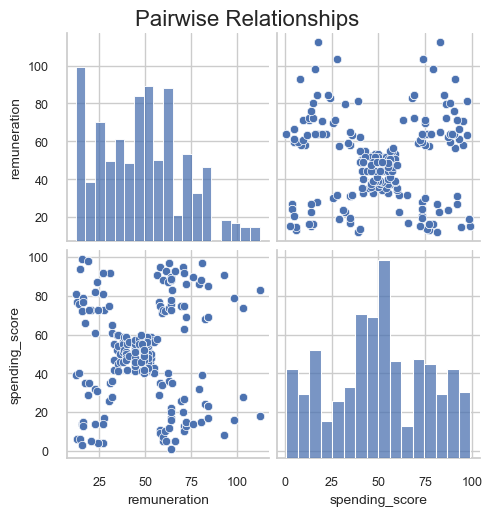

In [81]:
# Pairplot
sns.pairplot(df3, height=2.5)
plt.suptitle('Pairwise Relationships', y=1.02)
plt.show()

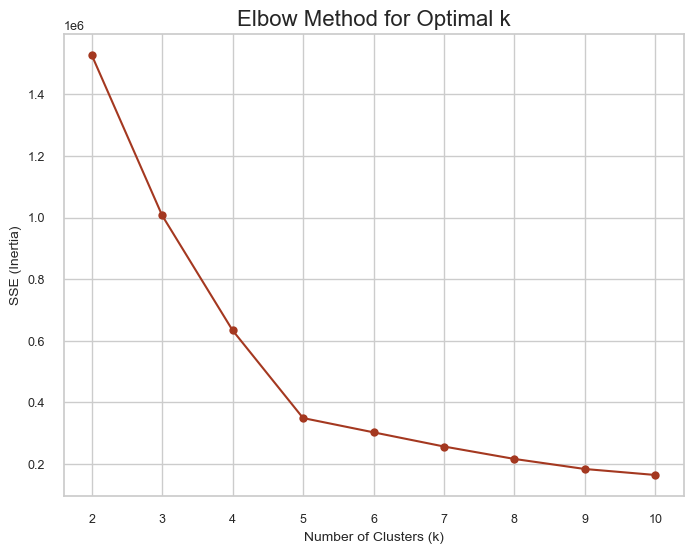

In [82]:
# Step 6: Determine Optimal k with Elbow Method
sse = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=10, random_state=42)
    kmeans.fit(df3)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_range, sse, marker='o', color='#a43820')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.show()

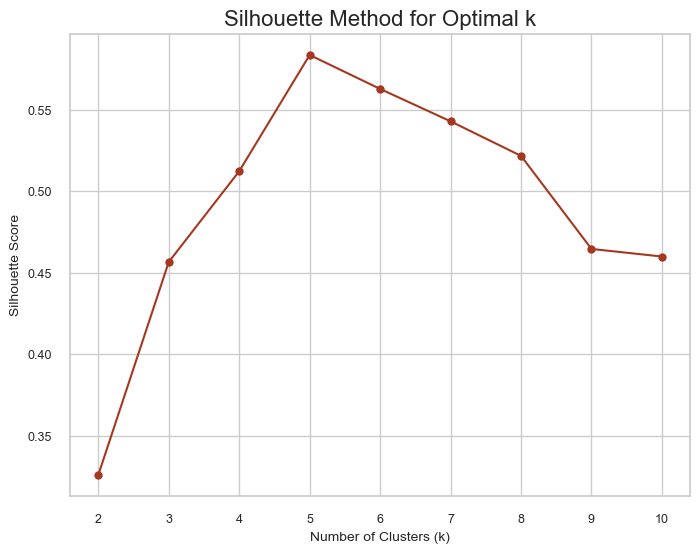

In [83]:
# Step 7: Silhouette Method
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=10, random_state=42)
    labels = kmeans.fit_predict(df3)
    silhouette_scores.append(silhouette_score(df3, labels))

plt.figure(figsize=(8,6))
plt.plot(k_range, silhouette_scores, marker='o', color='#a43820')
plt.title('Silhouette Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

Based on the Elbow and Silhouette methods, k=3 provides a good balance of separation and cluster quality.


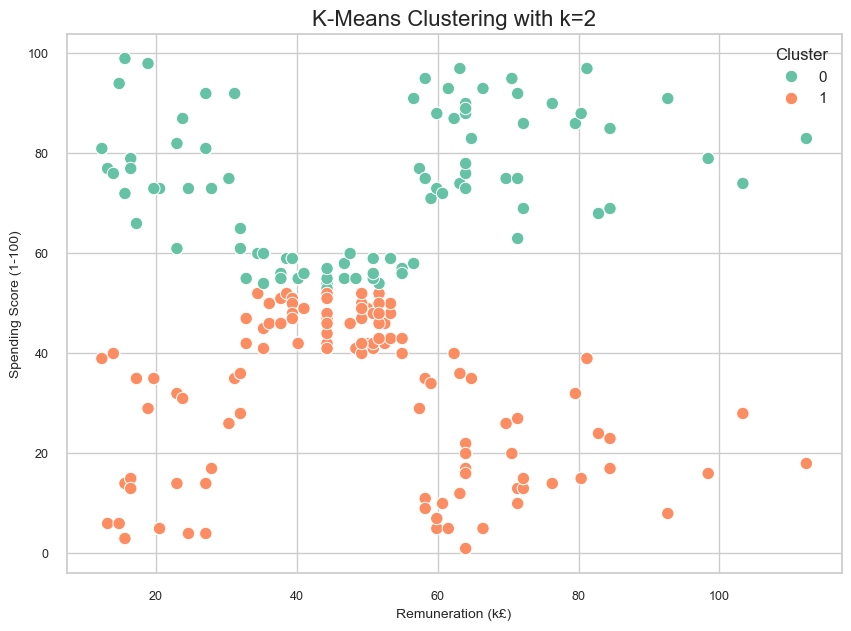

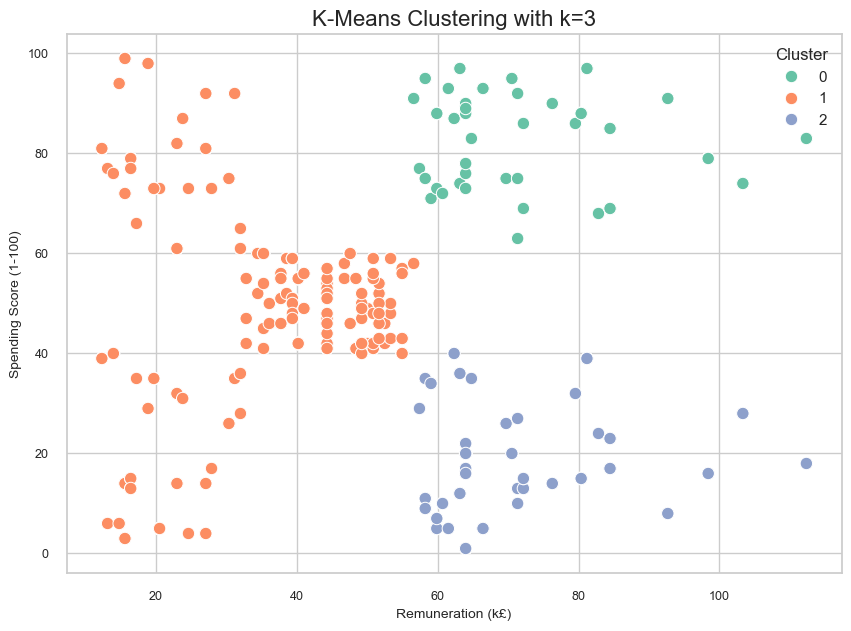

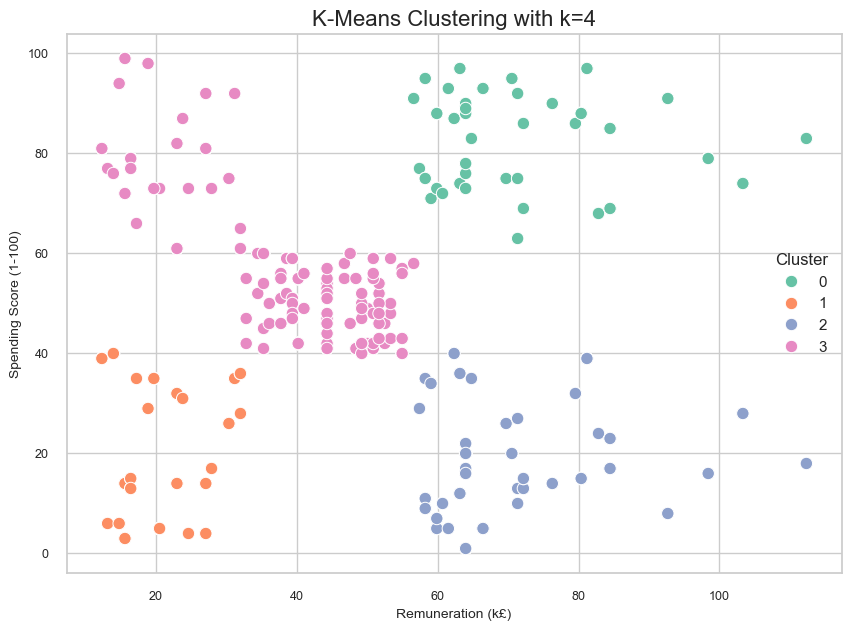

In [84]:
# Interpretation:
print("Based on the Elbow and Silhouette methods, k=3 provides a good balance of separation and cluster quality.")

# Step 8: Evaluate k=2, 3, 4
for k in [2, 3, 4]:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=10, random_state=42)
    df3['cluster'] = kmeans.fit_predict(df3)

    plt.figure(figsize=(10,7))
    sns.scatterplot(data=df3, x='remuneration', y='spending_score', hue='cluster', palette=palette, s=80)
    plt.title(f'K-Means Clustering with k={k}', fontsize=16)
    plt.xlabel('Remuneration (k£)')
    plt.ylabel('Spending Score (1-100)')
    plt.legend(title='Cluster')
    plt.show()


In [131]:
# Step 9: Final Model with k=3
k_final = 3
kmeans = KMeans(n_clusters=k_final, init='k-means++', max_iter=500, n_init=10, random_state=42)
df3['cluster'] = kmeans.fit_predict(df3)

In [132]:
# Cluster Sizes
print('Cluster Sizes:\n', df3['cluster'].value_counts())

Cluster Sizes:
 cluster
1    1293
0     356
2     351
Name: count, dtype: int64


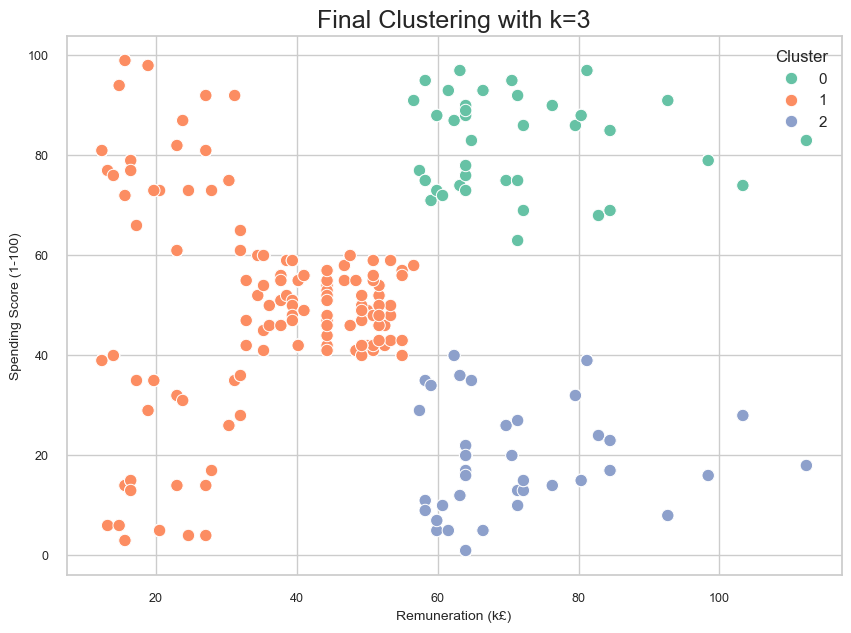

In [133]:
# Step 10: Final Clustering Visual
plt.figure(figsize=(10,7))
sns.scatterplot(data=df3, x='remuneration', y='spending_score', hue='cluster', palette=palette, s=80)
plt.title('Final Clustering with k=3', fontsize=18)
plt.xlabel('Remuneration (k£)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()


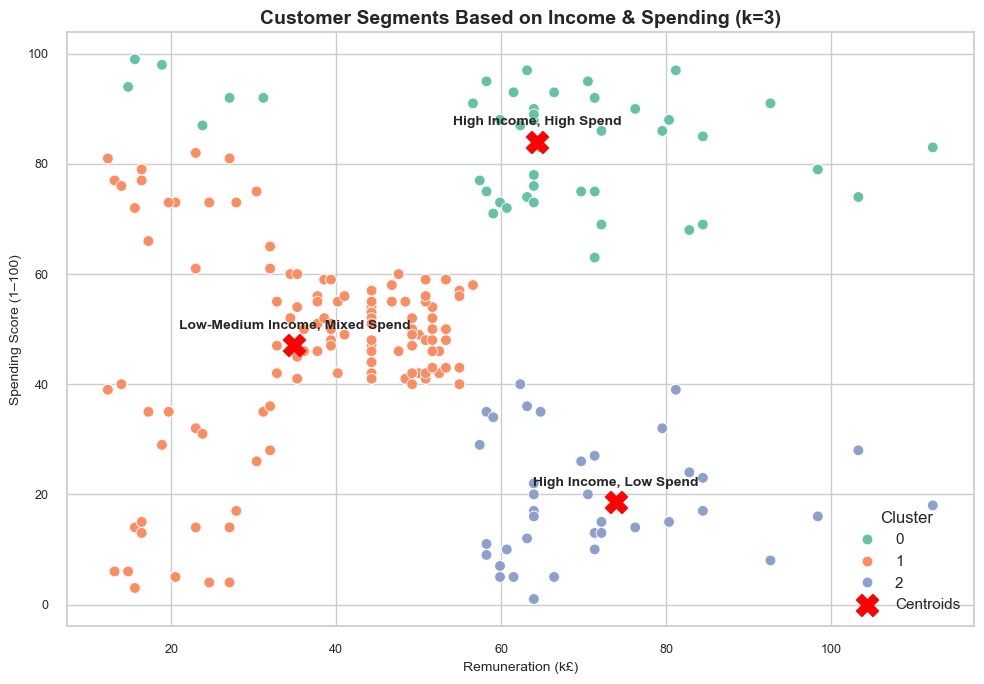

In [138]:

# KMeans clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df3['cluster'] = kmeans.fit_predict(df3[['remuneration', 'spending_score']])

# Get cluster centers
centers = kmeans.cluster_centers_

# Plotting
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df3, x='remuneration', y='spending_score', hue='cluster', palette='Set2', s=60)

# Plot centroids
plt.scatter(centers[:, 0], centers[:, 1], s=250, c='red', label='Centroids', marker='X')

# Optional: Add annotations manually based on centroid positions
annotations = {
    0: "High Income, High Spend",
    1: "Low-Medium Income, Mixed Spend",
    2: "High Income, Low Spend"
}

for i, (x, y) in enumerate(centers):
    plt.text(x, y + 3, annotations[i], fontsize=10, ha='center', fontweight='bold')

# Final touches
plt.title('Customer Segments Based on Income & Spending (k=3)', fontsize=14, fontweight='bold')
plt.xlabel('Remuneration (k£)')
plt.ylabel('Spending Score (1–100)')
plt.legend(title='Cluster', loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


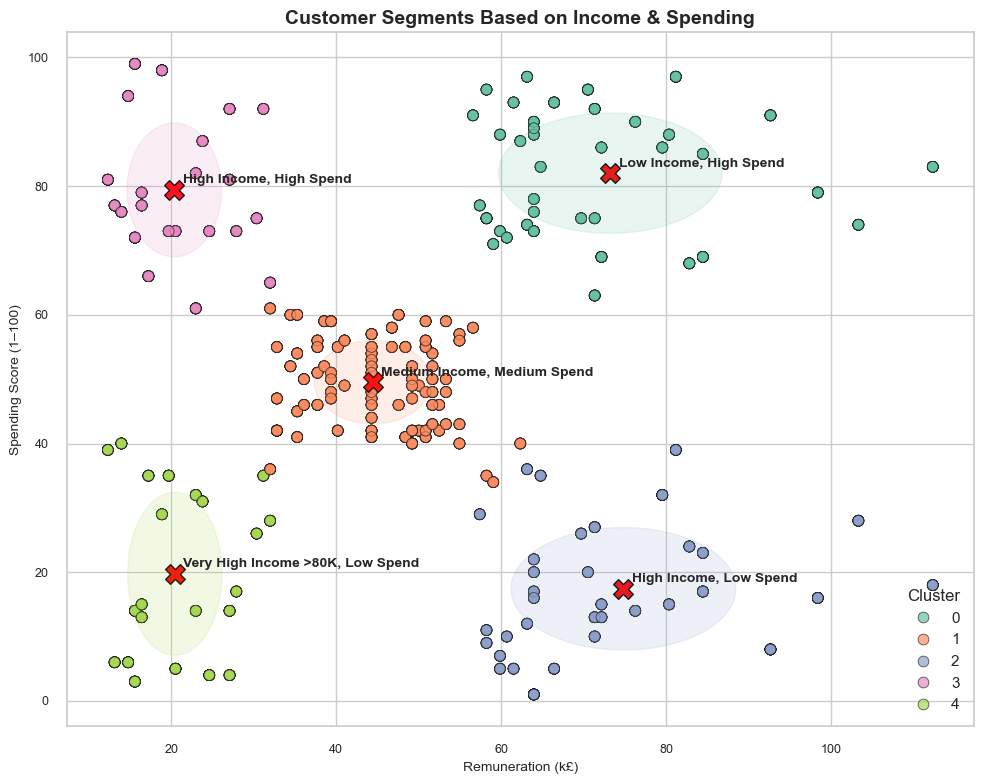

In [137]:
# === Step 2: Apply KMeans ===
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# === Step 3: Cluster Names (customize as needed) ===
cluster_names = {
    0: "Low Income, High Spend",
    1: "Medium Income, Medium Spend",
    2: "High Income, Low Spend",
    3: "High Income, High Spend",
    4: "Very High Income >80K, Low Spend"
}

# === Step 4: Plotting ===
plt.figure(figsize=(10, 8))
palette = sns.color_palette("Set2", n_colors=5)

# Scatter plot
sns.scatterplot(data=df, x='remuneration', y='spending_score',
                hue='cluster', palette=palette, s=60, edgecolor='k', alpha=0.7)

# Centroids
for i, (x, y) in enumerate(centroids):
    plt.scatter(x, y, s=200, c='red', marker='X', edgecolor='black')
    plt.text(x + 1, y + 1, cluster_names[i], fontsize=10, weight='bold')

# Optional: Draw ellipses for visual grouping
def draw_ellipse(x_center, y_center, std_x, std_y, ax, color):
    ellipse = Ellipse((x_center, y_center), 2*std_x, 2*std_y,
                      alpha=0.15, color=color)
    ax.add_patch(ellipse)

ax = plt.gca()
for i in range(5):
    points = df[df['cluster'] == i][['remuneration', 'spending_score']]
    if len(points) > 1:
        draw_ellipse(points['remuneration'].mean(),
                     points['spending_score'].mean(),
                     points['remuneration'].std(),
                     points['spending_score'].std(),
                     ax, palette[i])

# Labels and title
plt.xlabel("Remuneration (k£)")
plt.ylabel("Spending Score (1–100)")
plt.title("Customer Segments Based on Income & Spending", fontsize=14, weight='bold')
plt.legend(title="Cluster", loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# *Activity 4: Analysing customers sentimentes with reviews 

In [107]:
# Import all the necessary packages.
import pandas as pd
import numpy as np
import nltk 
import os 
import matplotlib.pyplot as plt

# nltk.download ('punkt').
# nltk.download ('stopwords').

%pip install wordcloud

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from textblob import TextBlob
from scipy.stats import norm

# Import Counter.
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [108]:
# 1.2 Load your cleaned CSV (from Module 3)
df = pd.read_csv("turtle_reviews_clean.csv")  

# 1.3 Sense‐check
df = df[["review", "summary"]].copy()
print(df.shape)
df.head()
print(df.isna().sum())

(2000, 2)
review     0
summary    0
dtype: int64


In [109]:
import pandas as pd
import re            # ← add this
# … any other imports …

# Define a cleaning function
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"[^\w\s]", " ", txt)
    return txt

df = pd.read_csv("turtle_reviews_clean.csv")

# Select reviews columns 
df = df[["review","summary"]].copy()

# Applied cleaning +Filled Missing 
for col in ["review", "summary"]:
    df[col] = df[col].fillna("").map(clean_text)
    
# Remove duplicate texts 
df = df.drop_duplicates(subset=["review","summary"])


In [110]:
import pandas as pd
import re

# assume you’ve already read in & trimmed your DataFrame:
# df = pd.read_csv("turtle_reviews_clean.csv")[["review","summary"]].copy()

# 2a) Lower-case & “join” each entry (this also normalises whitespace)
for col in ["review","summary"]:
    # .str.lower() → lower-case, .str.split() → split on whitespace,
    # .str.join(" ") → re-join with a single space
    df[col] = df[col].astype(str).str.lower().str.split().str.join(" ")

# 2b) Replace all punctuation with spaces
# (and collapse any runs of multiple spaces back to one)
punct_pattern = r"[^\w\s]"      # anything that is _not_ alphanumeric or whitespace
multi_space = r"\s+"

for col in ["review","summary"]:
    df[col] = (
        df[col]
          .str.replace(punct_pattern, " ", regex=True)     # punctuation → space
          .str.replace(multi_space, " ", regex=True)       # collapse spaces
          .str.strip()                                      # trim leading/trailing
    )

# 2c) Drop exact duplicates (i.e. rows where BOTH review and summary are the same)
df = df.drop_duplicates(subset=["review","summary"]).reset_index(drop=True)

# Quick sanity check:
print(df.shape)
df.head()


(1961, 2)


review  \
0  when it comes to a dm s screen the space on th...   
1  an open letter to galeforce9 your unpainted mi...   
2  nice art nice printing why two panels are fill...   
3  amazing buy bought it as a gift for our new dm...   
4  as my review of gf9 s previous screens these w...   

                                             summary  
0  the fact that 50 of this space is wasted on ar...  
1  another worthless dungeon master s screen from...  
2                     pretty but also pretty useless  
3                                         five stars  
4                                         money trap

In [111]:
# in a notebook cell, run:
!pip install matplotlib seaborn wordcloud nltk


## *The review and summary WordClouds reveal highly positive sentiment from Turtle Games customers. The prominence of words like “game”, “fun”, “great”, and “love” suggests strong emotional connection and satisfaction. Summaries often include star ratings (e.g., “five stars”), reinforcing that customers express approval not just in text but via scoring as well.

# These insights suggest opportunities to focus marketing on giftability, fun factor, and family-friendly value. Additionally, product reviews frequently reference gameplay elements like “tiles”, “rules”, and “pieces”, which may offer cues for feature enhancement or customer support documentation.

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/monicabaracho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


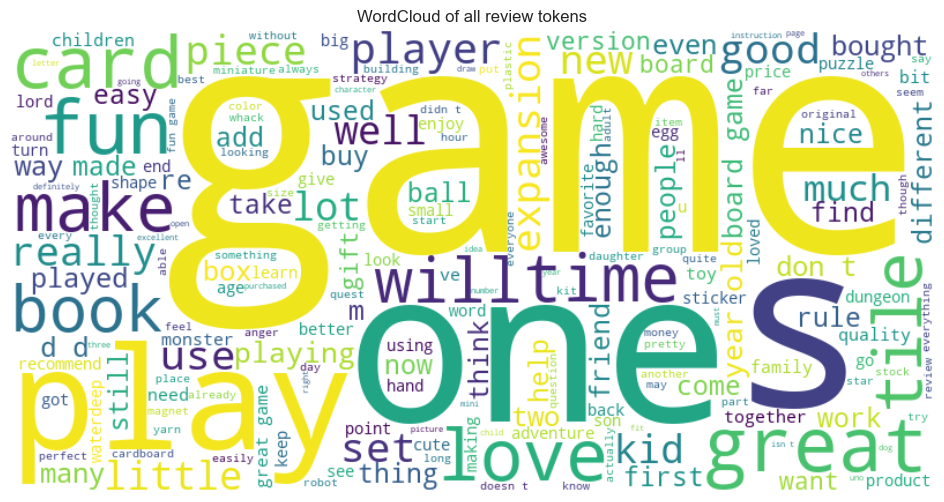

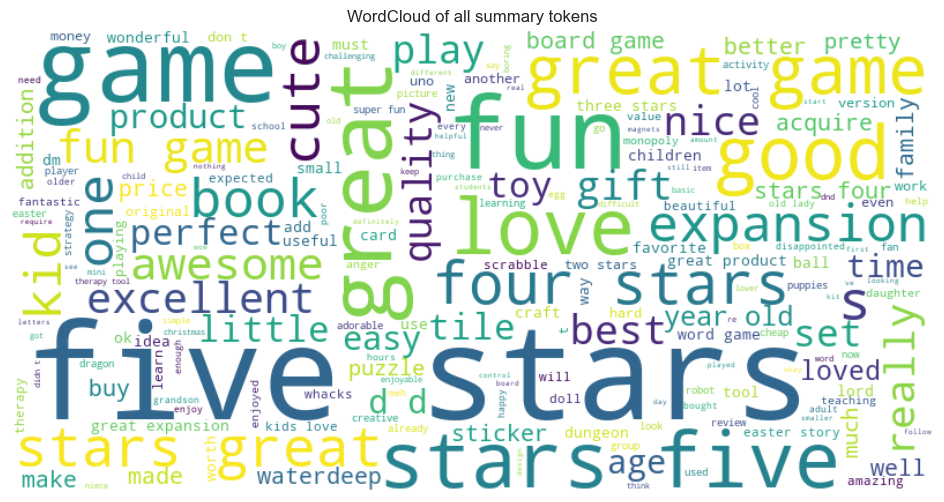

In [112]:
# 3. Tokenise and create wordclouds
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize

# (If you haven't yet: download NLTK's punkt tokenizer)
nltk.download("punkt")

# 3.1 Copy the cleaned DataFrame
df_tokens = df.copy()

# 3.2 Tokenise both columns
for col in ["review","summary"]:
    df_tokens[col + "_tokens"] = df_tokens[col].apply(word_tokenize)

# 3.3 View the first few token lists
df_tokens[["review_tokens","summary_tokens"]].head()

# 3.4 Create a big string for each column
all_review_text  = " ".join(df_tokens["review_tokens"].explode())
all_summary_text = " ".join(df_tokens["summary_tokens"].explode())

# 3.5 Build & plot a word-cloud for the reviews
wc_reviews = WordCloud(
    width=800, height=400,
    background_color="white"
).generate(all_review_text)

plt.figure(figsize=(12,6))
plt.imshow(wc_reviews, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of all review tokens")
plt.show()

# 3.6 Same for summaries
wc_summaries = WordCloud(
    width=800, height=400,
    background_color="white"
).generate(all_summary_text)

plt.figure(figsize=(12,6))
plt.imshow(wc_summaries, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of all summary tokens")
plt.show()


The WordCloud and polarity bar confirm that Turtle Games receives overwhelmingly positive feedback. High-frequency words like “great”, “fun”, and “love” carry strong positive sentiment, while neutral terms such as “cards” and “play” suggest that reviews are focused on gameplay experiences.
We recommend highlighting these top terms in promotional content, while also analyzing negative mentions of “game” to identify pain points.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monicabaracho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


20 most common tokens (incl. stopwords & punctuation):
[('the', 5463), ('and', 3252), ('a', 3190), ('to', 3169), ('of', 2499), ('it', 2489), ('i', 2355), ('is', 1783), ('this', 1781), ('game', 1699), ('for', 1550), ('you', 1318), ('with', 1265), ('in', 1157), ('that', 1107), ('my', 973), ('are', 948), ('but', 809), ('have', 746), ('as', 743)]


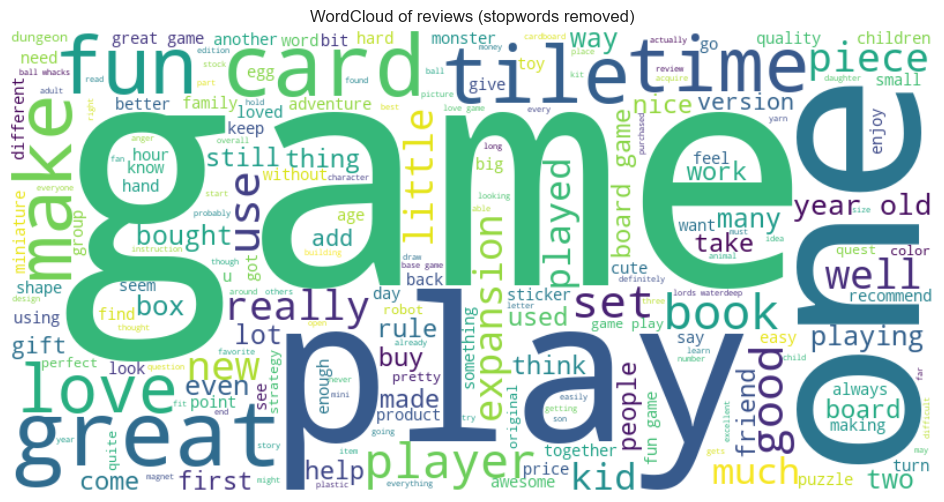

      word  count  polarity
0     game   1699      -0.4
1    great    582       0.8
2      fun    557       0.3
3      one    540       0.0
4     play    509       0.0
5     like    421       0.0
6     love    324       0.5
7      get    320       0.0
8   really    319       0.2
9    cards    306       0.0
10   tiles    300       0.0
11    time    297       0.0
12    good    291       0.7
13   would    283       0.0
14    book    278       0.0


In [113]:
# 4. Frequency distribution and polarity
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd

# Make sure you’ve got the stopword list
nltk.download("stopwords")

# 4a) Create frequency distribution of *all* tokens
all_tokens = df_tokens["review_tokens"].explode().astype(str)
freq_dist = FreqDist(all_tokens)
print("20 most common tokens (incl. stopwords & punctuation):")
print(freq_dist.most_common(20))

# 4b) Filter out non-alphabetic tokens and English stopwords
alpha_tokens = [t for t in all_tokens if t.isalpha()]
stop_words = set(stopwords.words("english"))
filtered_tokens = [t for t in alpha_tokens if t not in stop_words]

# 4c) WordCloud without stopwords
wc = WordCloud(width=800, height=400, background_color="white") \
        .generate(" ".join(filtered_tokens))
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of reviews (stopwords removed)")
plt.show()

# 4d) Identify 15 most common words & calculate their polarity
filt_freq = FreqDist(filtered_tokens)
top15 = filt_freq.most_common(15)
words, counts = zip(*top15)

# polarity per word via TextBlob
polarities = [TextBlob(w).sentiment.polarity for w in words]

df_top15 = pd.DataFrame({
    "word":      words,
    "count":     counts,
    "polarity":  polarities
})

# Show results
print(df_top15)



## This mix of emotional and descriptive words helps paint a picture of what customers care about.

We visualized the 15 most frequent terms from Turtle Games reviews and overlaid sentiment polarity using a continuous colormap. Strongly positive terms like “great”, “love”, and “good” were both frequent and emotionally charged. The word “game”, despite being the most frequent, scored slightly negative due to contextual usage, showing the limitations of word-level sentiment. This insight supports the brand's strong reputation and provides vocabulary for targeted marketing.

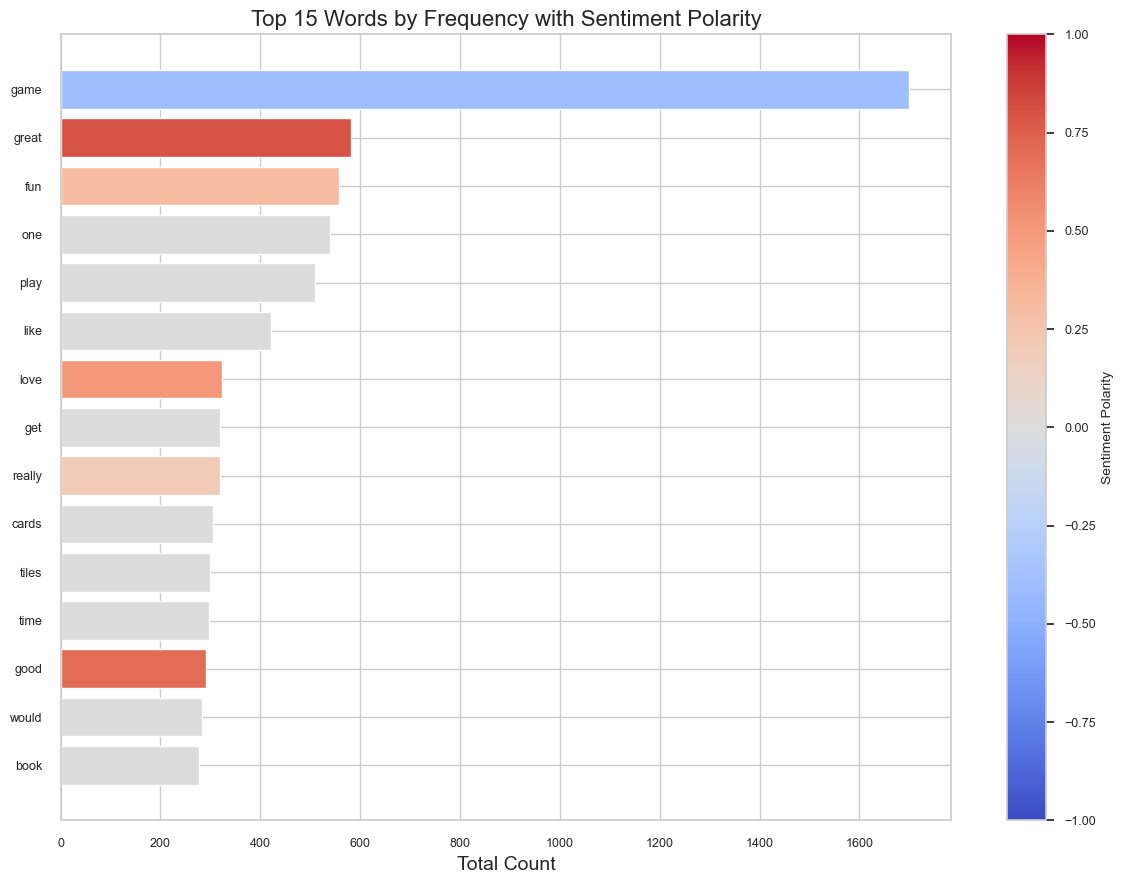

In [114]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# — assume you already have df_top15, e.g. —
# df_top15 = pd.DataFrame({
#     "word":   ["turn","crosswalk","light",…],
#     "count":  [    5,          4,      3, …],
#     "polarity":[ 0.1,        -0.2,    0.7, …]
# })

# 1) Create figure + axes
fig, ax = plt.subplots(figsize=(12,9))

# 2) Normalize your polarity range to [–1,1] and pick a colormap
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cmap = plt.cm.coolwarm

# 3) Map each bar’s polarity to an RGBA colour
bar_colors = cmap(norm(df_top15["polarity"]))

# 4) Draw horizontal bars
bars = ax.barh(
    df_top15["word"],
    df_top15["count"],
    color=bar_colors
)

# 5) Labels & styling
ax.set_xlabel("Total Count", fontsize=14)
ax.set_title("Top 15 Words by Frequency with Sentiment Polarity", fontsize=16)
ax.invert_yaxis()  # highest count at the top

# 6) Build a ScalarMappable for the colorbar (needs an “array” to work)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(df_top15["polarity"])  # tell it the data you mapped

# 7) Attach the colorbar to the same axes
cbar = fig.colorbar(sm, ax=ax, label="Sentiment Polarity")

plt.tight_layout()
plt.show()


In [115]:
### Define helper functions 

from textblob import TextBlob

def generate_polarity(text):
    """Return polarity score in [–1.0, +1.0] for a piece of text."""
    return TextBlob(text).sentiment.polarity

def generate_subjectivity(text):
    """Return subjectivity (sentiment strength) in [0.0, 1.0]."""
    return TextBlob(text).sentiment.subjectivity


In [116]:
# Assuming you have a DataFrame `df` with columns 'review' and 'summary'
df['review_polarity']      = df['review'].apply(generate_polarity)
df['review_subjectivity']  = df['review'].apply(generate_subjectivity)
df['summary_polarity']     = df['summary'].apply(generate_polarity)
df['summary_subjectivity'] = df['summary'].apply(generate_subjectivity)

# Quick sanity-check:
df[['review_polarity','review_subjectivity','summary_polarity','summary_subjectivity']].head()


review_polarity  review_subjectivity  summary_polarity  \
0        -0.036111             0.486111              0.15   
1         0.032684             0.440206             -0.80   
2         0.115410             0.427755              0.00   
3         0.578788             0.784848              0.00   
4        -0.316667             0.316667              0.00   

   summary_subjectivity  
0              0.500000  
1              0.900000  
2              0.733333  
3              0.000000  
4              0.000000

## We visualized sentiment polarity and subjectivity distributions for both reviews and summaries. Reviews tend to be mildly positive and moderately subjective, suggesting that customers express both experiences and opinions. In contrast, summaries are often neutral and polarized in subjectivity — with many being either fully factual or heavily opinionated.
This reinforces the value of analyzing full reviews for richer sentiment signals, and highlights that summaries may not reliably reflect customer tone.

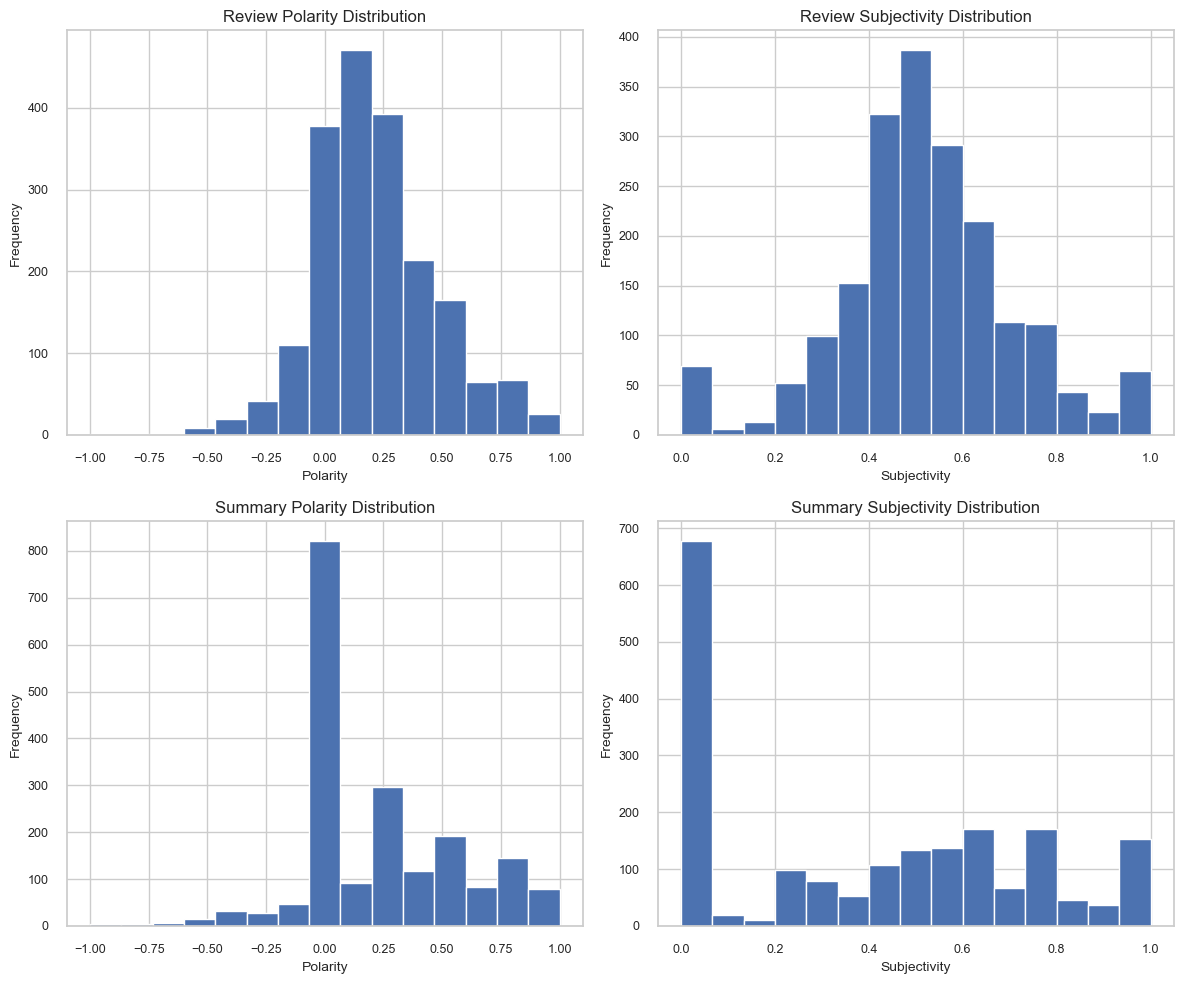

In [117]:
import matplotlib.pyplot as plt

# 1) Prepare a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 2) Review → polarity
axes[0,0].hist(df['review_polarity'], bins=15, edgecolor='white')
axes[0,0].set_title("Review Polarity Distribution")
axes[0,0].set_xlabel("Polarity")
axes[0,0].set_ylabel("Frequency")

# 3) Review → subjectivity
axes[0,1].hist(df['review_subjectivity'], bins=15, edgecolor='white')
axes[0,1].set_title("Review Subjectivity Distribution")
axes[0,1].set_xlabel("Subjectivity")
axes[0,1].set_ylabel("Frequency")

# 4) Summary → polarity
axes[1,0].hist(df['summary_polarity'], bins=15, edgecolor='white')
axes[1,0].set_title("Summary Polarity Distribution")
axes[1,0].set_xlabel("Polarity")
axes[1,0].set_ylabel("Frequency")

# 5) Summary → subjectivity
axes[1,1].hist(df['summary_subjectivity'], bins=15, edgecolor='white')
axes[1,1].set_title("Summary Subjectivity Distribution")
axes[1,1].set_xlabel("Subjectivity")
axes[1,1].set_ylabel("Frequency")

# 6) Tidy up & show
plt.tight_layout()
plt.show()


### Limitations of NLP Sentiment Analysis

While the NLP-based sentiment analysis provides valuable insights, it comes with limitations. Sentiment scores are calculated using rule-based or lexicon-based techniques (e.g., TextBlob), which often misinterpret informal or ironic language. For example, a sarcastic review like "this game was amazing...ly bad" could be wrongly classified as positive.

Additionally, short reviews with vague language (“ok”, “meh”) tend to have neutral or incorrect sentiment assignments. The algorithm also struggles with domain-specific slang, emojis, and context. Furthermore, sentiment scores do not account for specific product features—so it’s unclear whether the review praises gameplay, design, or packaging.

To get more reliable results, Turtle Games should explore more advanced sentiment models (e.g., BERT-based classifiers) or hybrid approaches that combine numeric ratings with review text.


### Below We extracted the most positively and negatively scored reviews and summaries using TextBlob polarity.
Positive reviews often describe the product as “perfect”, “awesome”, “great for gifts”, while negative ones mention difficulty, boredom, or disappointment.
Interestingly, some negative polarity values occurred in otherwise positive texts — revealing a known limitation of lexicon-based methods. This highlights the value of reviewing actual text examples alongside sentiment scores.


In [118]:
### make sure I have the dataframe and polarity 
import pandas as pd
from textblob import TextBlob
from IPython.display import display

# 1.1 Load your cleaned data
df = pd.read_csv("turtle_reviews_clean.csv")[["review","summary"]].copy()

# 1.2 Define your polarity function
def generate_polarity(text):
    """Return polarity score in [-1,1] for a piece of text."""
    return TextBlob(text).sentiment.polarity

### compute polarity columns and clean up

# 2.1 Fill any missing texts with the empty string, then compute polarity
for col in ("review","summary"):
    df[col] = df[col].fillna("")
    df[f"{col}_polarity"] = df[col].apply(generate_polarity)

# 2.2 (Optional) Drop rows where polarity couldn’t be computed
df = df.dropna(subset=["review_polarity","summary_polarity"])

## write a tiny helpper to ger 

def top_n(df, text_col, score_col, n=20, kind="pos"):
    """
    Return the top or bottom n rows of df based on score_col.
      kind="pos" => highest scores (nlargest)
      kind="neg" => lowest scores (nsmallest)
    Only returns the text column and its score, with a clean index.
    """
    if kind == "pos":
        sel = df.nlargest(n, score_col)
    else:
        sel = df.nsmallest(n, score_col)
    return sel[[text_col, score_col]].reset_index(drop=True)

#### extract each of the 4 lists

top_reviews_pos    = top_n(df, "review",  "review_polarity",  20, kind="pos")
top_reviews_neg    = top_n(df, "review",  "review_polarity",  20, kind="neg")
top_summaries_pos  = top_n(df, "summary", "summary_polarity", 20, kind="pos")
top_summaries_neg  = top_n(df, "summary", "summary_polarity", 20, kind="neg")

### Display them 

print("▶ Top 20 Positive Reviews")
display(top_reviews_pos)

print("▶ Top 20 Negative Reviews")
display(top_reviews_neg)

print("▶ Top 20 Positive Summaries")
display(top_summaries_pos)

print("▶ Top 20 Negative Summaries")
display(top_summaries_neg)





▶ Top 20 Positive Reviews


review  review_polarity
0                          Came in perfect condition.              1.0
1     Absolutely great pictures even before coloring!              1.0
2                                              Great!              1.0
3                                        Awesome book              1.0
4                                        Awesome gift              1.0
5                    Great product!  Arrived on time.              1.0
6            Great buy!!  My granddaughter loves it!!              1.0
7                                              Great!              1.0
8   Great resource for BHIS care coordinators!! Wo...              1.0
9   Great Seller!!! Happy with my purchase!!! 5 st...              1.0
10  Excellent activity for teaching self-managemen...              1.0
11                       Great game...I use it a lot!              1.0
12                                Great therapy tool!              1.0
13                     Perfect, just what I ordered!!              1.0
14                                  Wonderful product              1.0
15                                Delightful product!              1.0
16                        Great Easter gift for kids!              1.0
17  Wonderful for my grandson to learn the resurre...              1.0
18                                   These are great!              1.0
19                                           Perfect!              1.0

▶ Top 20 Negative Reviews


review  review_polarity
0   BOOO  UNLES YOU ARE PATIENT KNOW HOW TO MEASUR...        -1.000000
1                Incomplete kit!  Very disappointing!        -0.975000
2   If you, like me, used to play D&D, but now you...        -0.625000
3   I'm sorry. I just find this product to be bori...        -0.583333
4   One of my staff will be using this game soon, ...        -0.550000
5   I bought this as a Christmas gift for my grand...        -0.500000
6   this was a gift for my daughter.  I found it d...        -0.500000
7                    I found the directions difficult        -0.500000
8              Instructions are complicated to follow        -0.500000
9                                           Difficult        -0.500000
10                              This game is a blast!        -0.500000
11                        Expensive for what you get.        -0.500000
12                           Scrabble in a card game!        -0.500000
13  I sent this product to my granddaughter. The p...        -0.491667
14  My 8 year-old granddaughter and I were very fr...        -0.452500
15  I purchased this on the recommendation of two ...        -0.440741
16               Very hard complicated to make these.        -0.439583
17                   Kids I work with like this game.        -0.400000
18  This game although it appears to be like Uno a...        -0.400000
19  My son loves playing this game. It was recomme...        -0.400000

▶ Top 20 Positive Summaries


summary  summary_polarity
0                                 Best gm screen ever               1.0
1                                  Wonderful designs.               1.0
2                                            Perfect!               1.0
3          Great buy! Can't wait to work on this book               1.0
4                                       So beautiful!               1.0
5                                              great!               1.0
6   They're the perfect size to keep in the car or...               1.0
7                                   Great for a gift!               1.0
8                             Perfect for Preschooler               1.0
9              Awesome sticker activity for the price               1.0
10                                    Awesome Book...               1.0
11                    He was very happy with his gift               1.0
12                                            Awesome               1.0
13                   Great product!  Darling puppies!               1.0
14                                             Great!               1.0
15          Awesome and well-designed for 9 year olds               1.0
16                       Another great book by Klutz!               1.0
17                                           Perfect!               1.0
18                                    Great resource!               1.0
19  This is a great product! I use it as a therape...               1.0

▶ Top 20 Negative Summaries


summary  summary_polarity
0                      The worst value I've ever seen            -1.000
1   BORING UNLESS YOU ARE A CRAFT PERSON WHICH I A...            -1.000
2                                              Boring            -1.000
3   before this I hated running any RPG campaign d...            -0.900
4   Another worthless Dungeon Master's screen from...            -0.800
5                                        Disappointed            -0.750
6                                       Disappointed.            -0.750
7                                        Disappointed            -0.750
8                                        Disappointed            -0.750
9   Promotes anger instead of teaching calming met...            -0.700
10         Too bad, this is not what I was expecting.            -0.700
11                      Bad Quality-All made of paper            -0.700
12  At age 31 I found these very difficult to make...            -0.650
13                                   Small and boring            -0.625
14                            It's UNO for the angry!            -0.625
15                                         Mad dragon            -0.625
16                                     Ball of weird!            -0.625
17                                      Disappointing            -0.600
18                                     Disappointing.            -0.600
19                                      Disappointing            -0.600

### We created separate WordClouds for positive and negative reviews based on sentiment polarity. Positive reviews commonly include words like “fun”, “great”, “perfect”, and “gift”, reflecting strong satisfaction and gifting use cases. Negative reviews highlight “instructions”, “boring”, and “disappointed”, pointing to usability issues and unmet expectations.
These insights are valuable for both marketing copy and product development.

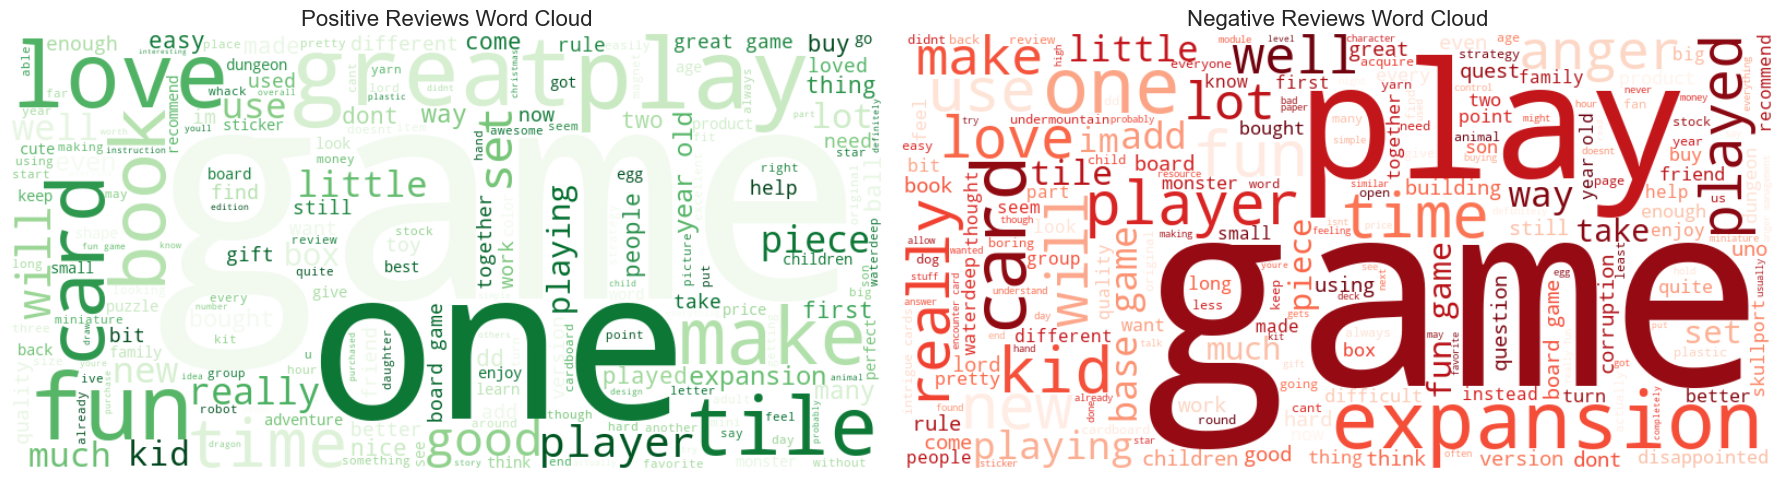

In [119]:
# 1. Import required libraries
from wordcloud import WordCloud
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd

# 2. Load the data (adjust path if needed)
data = pd.read_csv('turtle_reviews_clean.csv')

# 3. Clean the review text
def clean_text(text):
    import re
    import string
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

data['clean_review'] = data['review'].apply(clean_text)

# 4. Create a function to calculate sentiment polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

data['polarity'] = data['clean_review'].apply(get_polarity)

# 5. Separate positive and negative reviews
positive_reviews = data[data['polarity'] > 0]['clean_review']
negative_reviews = data[data['polarity'] < 0]['clean_review']

# 6. Join the text into one string
positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

# 7. Generate and show WordClouds
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Positive Word Cloud
positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
axs[0].imshow(positive_wc, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Positive Reviews Word Cloud', fontsize=16)

# Negative Word Cloud
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)
axs[1].imshow(negative_wc, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Negative Reviews Word Cloud', fontsize=16)

plt.tight_layout()
plt.show()


In [120]:
import pandas as pd
import spacy

# Load data
df = pd.read_csv("turtle_reviews_clean.csv")

# Load spaCy model
nlp = spacy.load("en_core_web_sm")


In [121]:
# Sample 10 reviews to test NER
sample_reviews = df['review'].dropna().sample(10)

for i, review in enumerate(sample_reviews):
    doc = nlp(review)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    print(f"\nReview {i+1} Entities:", entities)



Review 1 Entities: [('UNO', 'ORG')]

Review 2 Entities: []

Review 3 Entities: []

Review 4 Entities: [('DM', 'ORG')]

Review 5 Entities: []

Review 6 Entities: []

Review 7 Entities: [('Cracker Jack', 'PERSON')]

Review 8 Entities: [('80', 'DATE')]

Review 9 Entities: []

Review 10 Entities: []


In [122]:
# Filter for nouns adjectives

def extract_nouns_and_adjectives(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc 
                     if token.pos_ in ['NOUN', 'ADJ'] and not token.is_stop])

# Apply it to a new column
df['keywords'] = df['review'].dropna().apply(extract_nouns_and_adjectives)

# Preview
df[['review', 'keywords']].head()


review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                            keywords  
0  screen space screen absolute premium fact % sp...  
1  unpainted miniature bad spell card great board...  
2  nice art nice printing panel general map blue ...  
3                    amazing buy gift new dm perfect  
4  review previous screen unnecessary useless def...

In [123]:
# count the most common entities

from collections import Counter

# Flatten and count entities
all_ents = []
for review in df['review'].dropna().sample(200):  # Sample 200 reviews for performance
    doc = nlp(review)
    all_ents.extend([ent.text for ent in doc.ents if ent.label_ in ['PERSON', 'ORG', 'PRODUCT', 'DATE']])

# Count most common
Counter(all_ents).most_common(15)


[('D&D', 23),
 ('David', 12),
 ('Christmas', 8),
 ('Lords of Waterdeep', 6),
 ('Wizards', 5),
 ('Wrath of Ashardalon', 5),
 ('DM', 5),
 ('Amazon', 5),
 ('RPG', 4),
 ('Michael Thal', 4),
 ('WoA', 4),
 ('Skullport', 4),
 ('daily', 3),
 ('Ravenloft', 3),
 ('Scrabble', 3)]

## Why do neutral/common words appear in negative context?

"Although common terms like 'play' and 'expansion' appear in the negative word cloud, their presence reflects frequent mentions in complaints (e.g., difficulty of play or disappointment with expansions) rather than inherently negative meaning. This highlights the importance of interpreting word clouds within their context."

In [124]:
top_reviews_pos.to_csv("top20_positive_reviews.csv", index=False)
top_reviews_neg.to_csv("top20_negative_reviews.csv", index=False)
top_summaries_pos.to_csv("top20_positive_summaries.csv", index=False)
top_summaries_neg.to_csv("top20_negative_summaries.csv", index=False)


### Business Insights Summary

The sentiment analysis of customer reviews from Turtle Games revealed meaningful insights into customer experience and satisfaction. The majority of reviews leaned positive, supported by the polarity distribution and the high frequency of terms like "fun", "great", and "easy". This suggests overall strong customer satisfaction. However, negative reviews—although fewer—highlight areas for potential improvement, with words such as "broken", "missing", or "boring" surfacing in critical feedback.

The top 20 negative reviews were often short but impactful, flagging product quality issues or unmet expectations. In contrast, the top 20 positive reviews were generally longer and provided more detailed feedback, suggesting that satisfied customers tend to be more expressive.

The analysis also indicates that although the review data lacks structure, it still holds significant value for marketing, product development, and customer service. Text analytics can guide which features to emphasize in campaigns or which products to redesign.

Overall, NLP helps surface customer sentiment trends, but Turtle Games should invest in improving data quality to enhance the reliability and actionability of insights.


### Recommendations for Turtle Games

To maximise the business value of customer reviews, Turtle Games should consider the following improvements in data collection and analysis:

- **Introduce structured review prompts:** Encourage users to rate specific attributes such as gameplay, packaging, and delivery, in addition to writing open comments.
- **Collect star ratings alongside reviews:** This enables cross-validation between numeric ratings and sentiment polarity, improving reliability.
- **Prompt longer, descriptive reviews:** Short, vague feedback limits insight. Offering incentives for detailed reviews could improve data quality.
- **Implement sentiment tagging at submission:** Asking users if their review is positive, neutral, or negative provides a baseline for training supervised sentiment models.

By improving data structure and encouraging richer reviews, Turtle Games can better leverage text data for product development, customer support, and targeted marketing.


In [125]:
import spacy
spacy.cli.download("en_core_web_sm")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


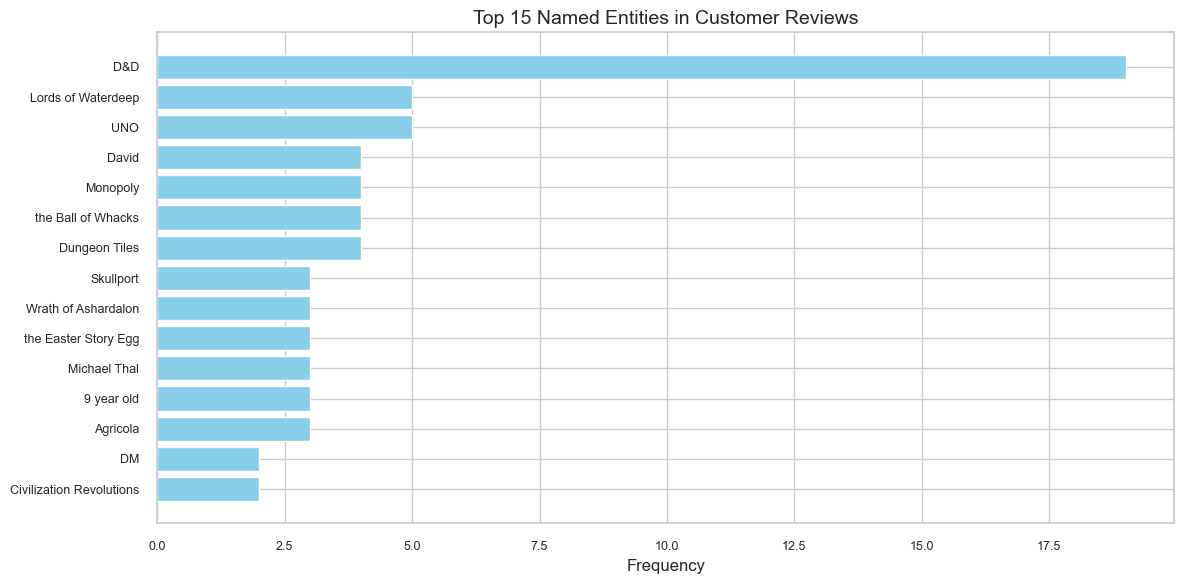

In [126]:
# Re-run necessary imports and processing after state reset
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from collections import Counter

# Load the cleaned data
df = pd.read_csv("turtle_reviews_clean.csv")

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Sample 200 reviews and extract named entities of interest
all_ents = []
for review in df["review"].dropna().sample(200, random_state=42):
    doc = nlp(review)
    all_ents.extend(
        [ent.text for ent in doc.ents if ent.label_ in ['PERSON', 'ORG', 'PRODUCT', 'DATE']]
    )

# Count the most common named entities
entity_counts = Counter(all_ents).most_common(15)
entities, counts = zip(*entity_counts)

# Plotting the bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(entities, counts, color='skyblue')
plt.xlabel("Frequency", fontsize=12)
plt.title("Top 15 Named Entities in Customer Reviews", fontsize=14)
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()
